In [73]:
import numpy as np
#import tensorflow as tf
#import keras
#from keras import backend as K
#from keras.datasets import mnist
#from keras.models import Sequential, Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, Input
#from keras import activations
#import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from math import *
from itertools import chain

#import import_ipynb
#from Utils import *
#from Model import *

from nbimporter import NotebookLoader
loader = NotebookLoader()
model = loader.load_module("Model")
utils = loader.load_module("Utils")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

Importing Jupyter notebook from Model.ipynb
Importing Jupyter notebook from Utils.ipynb
cuda:0


In [59]:
sigma_noise = [0.005, 0.005]
#image_size = (400, 300)
nbr_inliers=300
nbr_outliers=200
nbr_outliers_range = (0, 800)
size_patch = (2, 2)
scale_patch = (0.02, 0.02)


In [22]:
#input_dim = size_patch[0]*2+1
model_old_loss = model.Weights().to(DEVICE)



### Save&Load Model

In [60]:
def save_model_training(model, optimizer, file):
    torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, file)

def load_model_training(model, optimizer, file):
    checkpoint = torch.load(file, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    
def save_model(model, file):
    torch.save(model.state_dict(), file)

def load_model(model, file):
    model.load_state_dict(torch.load(file, map_location='cpu'))
    
    

### Train model

In [61]:
def loss_func(y1, y2):
    n = len(y1[0])
    s = 0
    for k in range(n):
        print(y1[k][0], y2[k][0])
        s += abs(y1[k][0]-y2[k][0])
    return s

def train_model(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, loss = 1, print_test=0, nbr_print=1, print_type=['test'], scale=100):
    ((x_train, y_train, datas_train, lines_train, outliers_train, points_train, y_v2_train), (x_test, y_test, datas_test, lines_test, outliers_test, points_test, y_v2_test)) = utils.generate_training_data(sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, loss = loss)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    print("len_train =", len(x_train))
    print("len_test =", len(x_test))
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-5))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    
    if print_test!=0:
            for _ in range(nbr_print):  
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(60, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training(model, datas_train[train_index], lines_train[train_index], outliers_train[train_index], y_v2_train[train_index], points_train[train_index], loss_fn, scale=scale, x_train=x_train)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(60, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training(model, datas_test[test_index], lines_test[test_index], outliers_test[test_index], y_v2_test[test_index], points_test[test_index], loss_fn, scale=scale)
                    plt.show()
                    plt.close()
        
        
    for k in range(epochs):
        loss_train = 0
        mean_w = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            mean_w += utils.mean_weights(y_predict).item()
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        #model.eval()  # <-- here
        #with torch.no_grad():
        #    loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
        #    m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl))#, " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        print("mean weights train =", mean_w/len(train_dl))
        if print_test!=0 and (k+1)%print_test==0:
            for _ in range(nbr_print):
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(60, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training(model, datas_train[train_index], lines_train[train_index], outliers_train[train_index], y_v2_train[train_index], points_train[train_index], loss_fn, scale=scale, x_train=x_train)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(60, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training(model, datas_test[test_index], lines_test[test_index], outliers_test[test_index], y_v2_test[test_index], points_test[test_index], loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                
        
        #if k == epochs - 1:
        #    last_weight = model(x_test.to(DEVICE))
        #    print(last_weight)
        #    print(y_test)
        #    print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))
            

def train_model_patch(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, size_patch, scale_patch, print_test=0, nbr_print=1, lr = 10**(-4), print_type=['test'], scale=100):
    ((x_train, y_train, datas_train, lines_train, outliers_train, points_train, y_v2_train), (x_test, y_test, datas_test, lines_test, outliers_test, points_test, y_v2_test)) = utils.generate_training_data_patch(sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, size_patch, scale_patch)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("data generated")
    
    # Train step
    x_train1, x_train2, x_train3 = x_train
    train_ds = TensorDataset(x_train1, x_train2, x_train3, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    x_test1, x_test2, x_test3 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, x_test3, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    
    
    if print_test!=0:
        for _ in range(nbr_print):  
            if 'train' in print_type:
                print("===================== Train ===================")
                plt.figure(1, figsize=(60, 10))
                train_index = np.random.randint(len(datas_train))
                utils.plot_weights_during_training_patch(model, datas_train[train_index], lines_train[train_index], outliers_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
            if 'test' in print_type:
                print("===================== Test ===================")
                plt.figure(1, figsize=(60, 10))
                test_index = np.random.randint(len(datas_test))
                utils.plot_weights_during_training_patch(model, datas_test[test_index], lines_test[test_index], outliers_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
        
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, xb3, yb in train_dl:
            xb1, xb2, xb3, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2, xb3))
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, xb3, yb in valid_dl:
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float()))
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl), " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        if print_test!=0 and (k+1)%print_test==0:
            for _ in range(nbr_print):  
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(60, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training_patch(model, datas_train[train_index], lines_train[train_index], outliers_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(60, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training_patch(model, datas_test[test_index], lines_test[test_index], outliers_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                    
        #if k == epochs - 1:
            #last_weight = model((x_test1.to(DEVICE).float(), x_test2.to(DEVICE).float(), x_test3.to(DEVICE).float()))
            #print(last_weight)
            #print(y_test)
            #print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))




In [6]:
#model_simple = model.Weights().to(DEVICE)

In [7]:
#train_model(model_simple, sigma_noise, 200, (20,20), 500, 500, nbr_inliers, (200, 200), print_test=20, nbr_print=5, print_type=['train', 'test'], scale=75)

In [8]:
model_patch = model.Weights2().to(DEVICE)

In [ ]:
scale_patch = (0.008, 0.008)
train_model_patch(model_patch, sigma_noise, 400, (15, 20), 100, 200, nbr_inliers, (200, 200), size_patch, scale_patch, print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test'], scale=75)

In [ ]:
save_model(model_patch, "model_patch")

In [52]:
model_patch_load = model.Weights2().to(DEVICE)
load_model(model_patch_load, "model_patch")

In [ ]:
scale_patch = (0.008, 0.008)
plt.figure(1, figsize=(70, 10))
plot_weights_patch(model_patch_load, sigma_noise, nbr_inliers, (200, 200), size_patch, scale_patch, scale=75)

In [38]:
model_patch_outliers = model.Weights2().to(DEVICE)

In [ ]:
scale_patch = (0.008, 0.008)
train_model_patch(model_patch_outliers, sigma_noise, 400, (15, 20), 300, 200, nbr_inliers, (50, 400), size_patch, scale_patch, print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test'], scale=75)

In [64]:
save_model(model_patch_outliers, "model_patch_outliers")

In [65]:
model_patch_outliers_load = model.Weights2().to(DEVICE)
load_model(model_patch_outliers_load, "model_patch_outliers")

In [ ]:
scale_patch = (0.008, 0.008)
plt.figure(1, figsize=(70, 10))
plot_weights_patch(model_patch_outliers_load, sigma_noise, nbr_inliers, (50, 400), size_patch, scale_patch, scale=75)

In [62]:
def train_model_patch_multi_lines(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, nbr_lines_range, size_patch, scale_patch, print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test'], scale=75):
    ((x_train, y_train, datas_train, lines_train, outliers_train, index_train, points_train, y_v2_train), (x_test, y_test, datas_test, lines_test, outliers_test, index_test, points_test, y_v2_test)) = utils.generate_training_data_patch_multi_lines(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale_patch)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    print("len test", len(y_test))
    print("len train", len(y_train))
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-7))
    print("data generated")
    
    # Train step
    x_train1, x_train2, x_train3 = x_train
    train_ds = TensorDataset(x_train1, x_train2, x_train3, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    x_test1, x_test2, x_test3 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, x_test3, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    if print_test!=0:
        for _ in range(nbr_print):  
            if 'train' in print_type:
                print("===================== Train ===================")
                plt.figure(1, figsize=(70, 10))
                train_index = np.random.randint(len(datas_train))
                utils.plot_weights_during_training_patch_multi_lines(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
            if 'test' in print_type:
                print("===================== Test ===================")
                plt.figure(1, figsize=(70, 10))
                test_index = np.random.randint(len(datas_test))
                utils.plot_weights_during_training_patch_multi_lines(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
    
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, xb3, yb in train_dl:
            xb1, xb2, xb3, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2, xb3))
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, xb3, yb in valid_dl:
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float()))
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl), " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        if print_test!=0 and (k+1)%print_test==0:
            for _ in range(nbr_print):  
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(70, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training_patch_multi_lines(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(70, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training_patch_multi_lines(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
        
        #if k == epochs - 1:
            #last_weight = model(x_test.to(DEVICE))
            #print(last_weight)
            #print(y_test)
            #print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))

In [ ]:
#model_patch = model.Weights2().to(DEVICE)

In [ ]:
#scale_patch = (0.008, 0.008)
#print("strart....")
#train_model_patch_multi_lines(model_patch_multi, sigma_noise, 200, (15, 20), 100, 200, nbr_inliers, (50, 300), (1, 1), size_patch, scale_patch, print_test=25, nbr_print=2, lr=10**(-4), print_type=['train', 'test'], scale=75)
#print("end")

In [ ]:
model_patch_multi = model.Weights2().to(DEVICE)

In [ ]:
scale_patch = (0.008, 0.008)
print("start....")
train_model_patch_multi_lines(model_patch_multi, sigma_noise, 300, (20, 20), 200, 300, nbr_inliers, (0, 0), (2, 2), size_patch, scale_patch, print_test=50, nbr_print=2, lr=10**(-4), print_type=['train', 'test'], scale=75)
print("end")

In [69]:
save_model(model_patch_multi, "model_patch_multi")

In [70]:
model_patch_multi_load = model.Weights2().to(DEVICE)
load_model(model_patch_multi_load, "model_patch_multi")

In [ ]:
scale_patch = (0.008, 0.008)
plt.figure(1, figsize=(60, 10))
plot_weights_patch_multi(model_patch_multi_load, sigma_noise, (2, 2), nbr_inliers, (0, 0), size_patch, scale_patch, scale=50)

In [47]:
model_patch_multi2 = model.Weights2().to(DEVICE)

In [ ]:
scale_patch = (0.008, 0.008)
print("start....")
train_model_patch_multi_lines(model_patch_multi2, sigma_noise, 300, (20, 20), 600, 300, nbr_inliers, (100, 300), (1, 2), size_patch, scale_patch, print_test=50, nbr_print=2, lr=10**(-4), print_type=['train', 'test'], scale=75)
print("end")

In [63]:
def train_model_multi_lines(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, nbr_lines_range=(1, 1), print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test'], scale=75):
    ((x_train, y_train, datas_train, lines_train, outliers_train, index_train, points_train, y_v2_train), (x_test, y_test, datas_test, lines_test, outliers_test, index_test, points_test, y_v2_test)) = utils.generate_training_data_multi_lines(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    print(len(x_test))
    print(len(x_train))
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-7))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    if print_test!=0:
        for _ in range(nbr_print):  
            if 'train' in print_type:
                print("===================== Train ===================")
                plt.figure(1, figsize=(60, 10))
                train_index = np.random.randint(len(datas_train))
                utils.plot_weights_during_training_multi_lines(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], loss_fn, scale=scale)
                plt.show()
                plt.close()
            if 'test' in print_type:
                print("===================== Test ===================")
                plt.figure(1, figsize=(60, 10))
                test_index = np.random.randint(len(datas_test))
                utils.plot_weights_during_training_multi_lines(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], loss_fn, scale=scale)
                plt.show()
                plt.close()
                
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
            m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl), " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        if print_test!=0 and (k+1)%print_test==0:
            for _ in range(nbr_print):  
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(60, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training_multi_lines(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(60, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training_multi_lines(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], loss_fn,scale=scale)
                    plt.show()
                    plt.close()
        
        #if k == epochs - 1:
            #last_weight = model(x_test.to(DEVICE))
            #print(last_weight)
            #print(y_test)
            #print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))

In [7]:
model_multi0 = model.Weights().to(DEVICE)

In [ ]:
train_model_multi_lines(model_multi0, sigma_noise, 2, (1, 100), 200, 50, nbr_inliers, (50, 300), nbr_lines_range=(1, 1), print_test=20, nbr_print=2, lr=10**(-4))

In [64]:
def train_model_patch_coef(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, nbr_lines_range, size_patch, scale_patch, print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test']):
    ((x_train, y_train, datas_train, lines_train, outliers_train, index_train), (x_test, y_test, datas_test, lines_test, outliers_test, index_test)) = utils.generate_training_data_patch_coef(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale_patch)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    print("len test", len(y_test))
    print("len train", len(y_train))
    optimizer = optim.Adam(model.parameters(), lr=10**(-7))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    if print_test!=0:
        if 'train' in print_type:
            print("===================== Train ===================")
            plt.figure(1, figsize=(40, 10))
            train_index = np.random.randint(len(datas_train))
            utils.plot_weights_during_training_patch_coef(model, datas_train[train_index], lines_train[train_index], index_train[train_index], size_patch, scale_patch, nbr_print=nbr_print)
            plt.show()
            plt.close()
        if 'test' in print_type:
            print("===================== Test ===================")
            plt.figure(1, figsize=(40, 10))
            test_index = np.random.randint(len(datas_test))
            utils.plot_weights_during_training_patch_coef(model, datas_test[test_index], lines_test[test_index], index_test[test_index], size_patch, scale_patch, nbr_print=nbr_print)
            plt.show()
            plt.close()
    
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, yb in train_dl:
            xb1, yb = xb1.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb1)
            #print(xb.shape)
            #print(y_predict, yb)
            prt=False
            if print_test!=0 and (k+1)%print_test==0:
                prt=True
            loss = utils.loss_coef_list(y_predict.squeeze(), yb, prt=prt)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, yb in valid_dl:
                predict_test = model(xb1.to(DEVICE).float())
                loss_eval += utils.loss_coef_list(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl), " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        if print_test!=0 and (k+1)%print_test==0:
            if 'train' in print_type:
                print("===================== Train ===================")
                plt.figure(1, figsize=(40, 10))
                train_index = np.random.randint(len(datas_train))
                utils.plot_weights_during_training_patch_coef(model, datas_train[train_index], lines_train[train_index], index_train[train_index], size_patch, scale_patch, nbr_print=nbr_print)
                plt.show()
                plt.close()
            if 'test' in print_type:
                print("===================== Test ===================")
                plt.figure(1, figsize=(40, 10))
                test_index = np.random.randint(len(datas_test))
                utils.plot_weights_during_training_patch_coef(model, datas_test[test_index], lines_test[test_index], index_test[test_index], size_patch, scale_patch, nbr_print=nbr_print)
                plt.show()
                plt.close()
        
        #if k == epochs - 1:
            #last_weight = model(x_test.to(DEVICE))
            #print(last_weight)
            #print(y_test)
            #print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))

In [50]:
model_coef = model.CoefLine().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_coef(model_coef, sigma_noise, 2, 100, 1000, 20, nbr_inliers, (100, 100), (1, 1), size_patch, scale_patch, print_test=100, nbr_print=1, lr=10**(-2), print_type=['train'])
print("end")


In [9]:
save_model(model_coef, "model_coef")

In [ ]:
model_coef_load = model.CoefLine().to(DEVICE)
load_model(model_coef_load, "model_patch_multi")

In [8]:
model_coef_outliers = model.CoefLine().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_coef(model_coef_outliers, sigma_noise, 2, 100, 2000, 20, nbr_inliers, (100, 100), (1, 1), size_patch, scale_patch, print_test=500, nbr_print=1, lr=10**(-4), print_type=['train', 'test'])
print("end")


In [ ]:
save_model(model_coef_outliers, "model_coef_outliers")

In [ ]:
model_coef_multi = model.CoefLine().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_coef(model_coef_multi, sigma_noise, 300, 100, 800, 300, nbr_inliers, (0, 0), (2, 2), size_patch, scale_patch, print_test=100, nbr_print=2, lr=10**(-4), print_type=['train', 'test'])
print("end")


In [ ]:
save_model(model_coef_multi, "model_coef_multi")

In [ ]:
model_coef_multi_outliers = model.CoefLine().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_coef(model_coef_multi_outliers, sigma_noise, 300, 100, 600, 200, nbr_inliers, (100, 100), (2, 2), size_patch, scale_patch, print_test=100, nbr_print=2, lr=10**(-4), print_type=['train', 'test'])
print("end")

In [ ]:
save_model(model_coef_multi_outliers, "model_coef_multi_outliers")

In [65]:
def train_model_patch_3D(model, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers_range, nbr_lines_range, size_patch, scale_patch, print_test=50, nbr_print=3, lr=10**(-5), print_type=['train', 'test'], scale=75):
    ((x_train, y_train, datas_train, lines_train, outliers_train, index_train, points_train, y_v2_train), (x_test, y_test, datas_test, lines_test, outliers_test, index_test, points_test, y_v2_test)) = utils.generate_training_data_patch_3D(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale_patch)
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    print("len test", len(y_test))
    print("len train", len(y_train))
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-7))
    print("data generated")
    
    # Train step
    x_train1, x_train2 = x_train
    print(x_train1.shape)
    train_ds = TensorDataset(x_train1, x_train2, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    #print(len(train_dl))
    
    x_test1, x_test2 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    
    if print_test!=0:
        for _ in range(nbr_print):  
            if 'train' in print_type:
                print("===================== Train ===================")
                plt.figure(1, figsize=(70, 10))
                train_index = np.random.randint(len(datas_train))
                utils.plot_weights_during_training_patch_3D(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
            if 'test' in print_type:
                print("===================== Test ===================")
                plt.figure(1, figsize=(70, 10))
                test_index = np.random.randint(len(datas_test))
                utils.plot_weights_during_training_patch_3D(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                plt.show()
                plt.close()
    
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, yb in train_dl:
            xb1, xb2, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), yb.to(DEVICE).float()
            xb1 = xb1.squeeze()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2))
            #y_predict = model(xb1)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, yb in valid_dl:
                xb1  = xb1.squeeze()
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float()))
                #predict_test = model(xb1.to(DEVICE).float())
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train/len(train_dl), " ; loss_eval = ", loss_eval.item()/len(valid_dl))
        if print_test!=0 and (k+1)%print_test==0:
            for _ in range(nbr_print):  
                if 'train' in print_type:
                    print("===================== Train ===================")
                    plt.figure(1, figsize=(70, 10))
                    train_index = np.random.randint(len(datas_train))
                    utils.plot_weights_during_training_patch_3D(model, datas_train[train_index], lines_train[train_index], index_train[train_index], y_v2_train[train_index], points_train[train_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
                if 'test' in print_type:
                    print("===================== Test ===================")
                    plt.figure(1, figsize=(70, 10))
                    test_index = np.random.randint(len(datas_test))
                    utils.plot_weights_during_training_patch_3D(model, datas_test[test_index], lines_test[test_index], index_test[test_index], y_v2_test[test_index], points_test[test_index], size_patch, scale_patch, loss_fn, scale=scale)
                    plt.show()
                    plt.close()
        
        #if k == epochs - 1:
            #last_weight = model(x_test.to(DEVICE))
            #print(last_weight)
            #print(y_test)
            #print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))

In [29]:
model_patch_3D = model.Weights3D().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_3D(model_patch_3D, sigma_noise, 400, (20, 20), 2000, 400, nbr_inliers, (200, 200), (1, 1), size_patch, scale_patch, print_test=500, nbr_print=2, lr=10**(-4), print_type=['train', 'test'])
print("end")

In [31]:
save_model(model_patch_3D, "model_patch_3D")

In [32]:
model_patch_3D_multi = model.Weights3D().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_3D(model_patch_3D_multi, sigma_noise, 400, (20, 20), 1000, 400, nbr_inliers, (50, 400), (2, 5), size_patch, scale_patch, print_test=200, nbr_print=2, lr=10**(-4), print_type=['train', 'test'])
print("end")

In [53]:
save_model(model_patch_3D_multi, "model_patch_3D_multi")

In [ ]:
model_patch_multi = model.Weights2().to(DEVICE)

In [ ]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_patch_multi_lines(model_patch_multi, sigma_noise, 300, (15, 15), 500, 300, nbr_inliers, (50, 400), (2, 2), size_patch, scale_patch, print_test=250, nbr_print=2, lr=10**(-4), print_type=['train', 'test'], scale=75)
print("end")

In [ ]:
save_model(model_patch_multi, "model_patch_multi")

In [76]:
model_multi = model.Weights().to(DEVICE)

start....
12000
108000
data generated
===================== Train ===================
len y in set = 400
loss_norm = tensor(0.0144, device='cuda:0')
max/min ref = 0.4590768482393828 0
max/min =  0.4590768482393828 0
mean = 0.07640443486507294
len = 1000
max/min =  0.21571463346481323 0.0
mean = 0.059530045837163925
len = 1000
loss_MSE = tensor(0.0144)


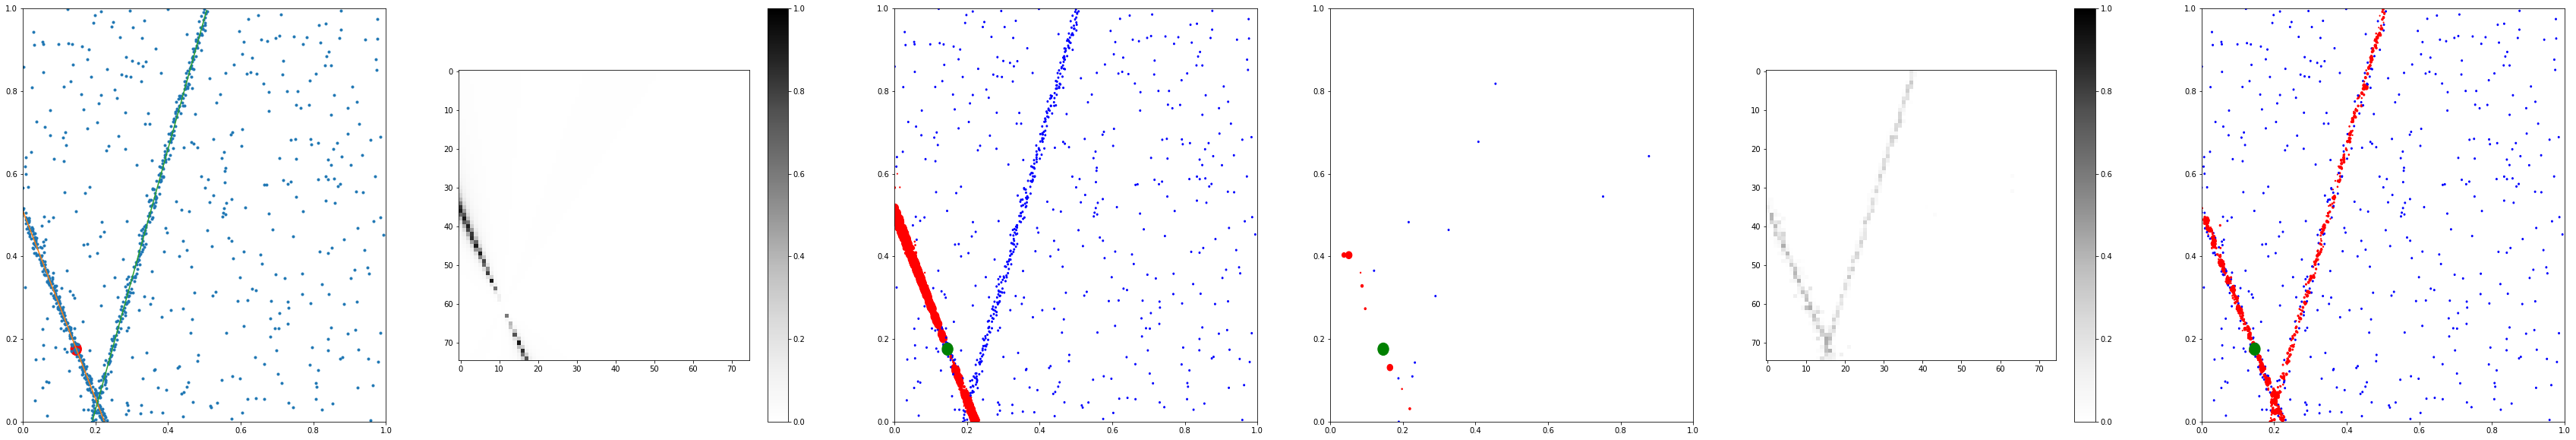

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0076, device='cuda:0')
max/min ref = 0.30783718828007456 0
max/min =  0.30783718828007456 0
mean = 0.05292008291551306
len = 987
max/min =  0.12856271862983704 0
mean = 0.05667142942547798
len = 987
loss_MSE = tensor(0.0076)


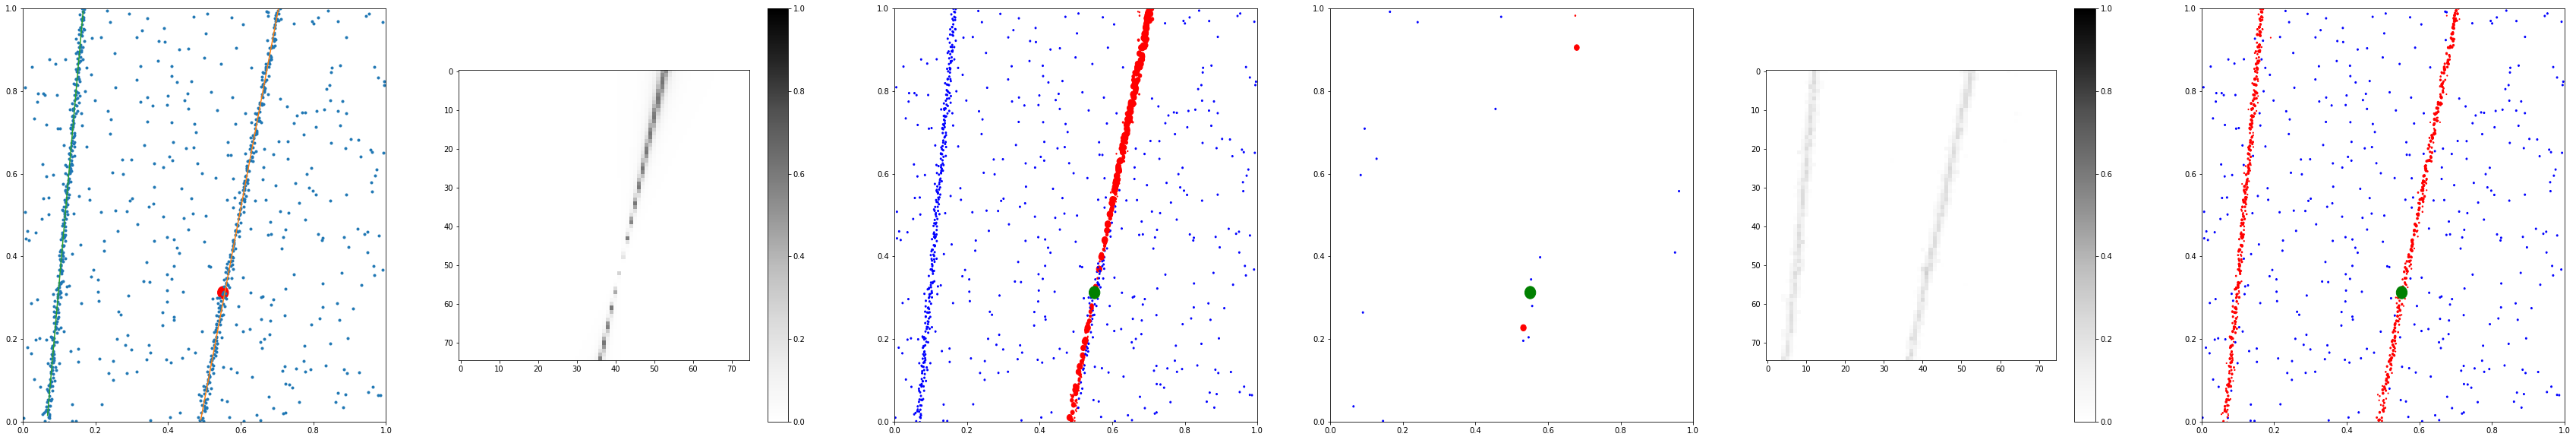

===================== Train ===================
len y in set = 400
loss_norm = tensor(1.4862e-07, device='cuda:0')
max/min ref = 0.0008660381001170947 0
max/min =  0.0008660381001170947 0
mean = 0.0003156928869801798
len = 802
max/min =  0.0 0.0
mean = 0.0
len = 802
loss_MSE = tensor(1.4862e-07)


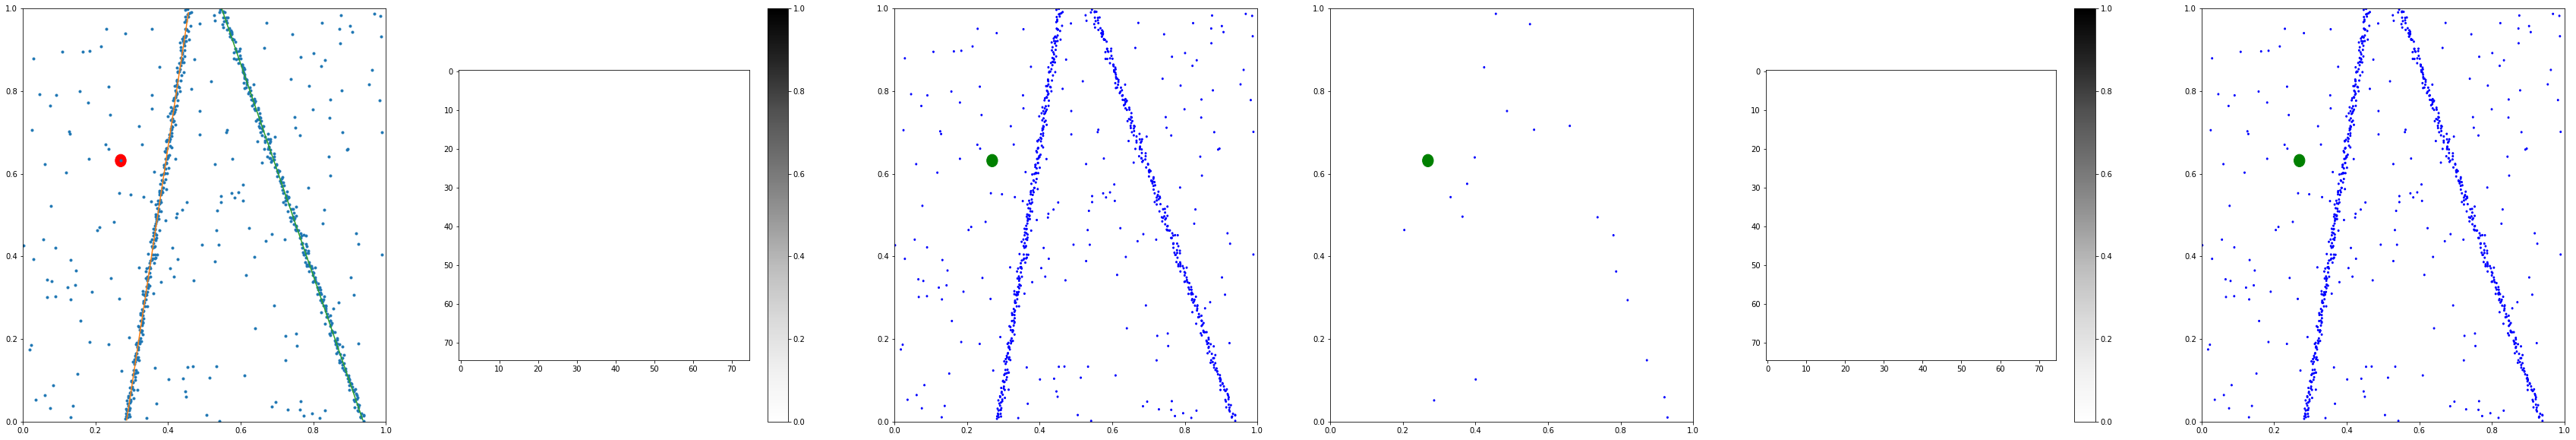

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0094, device='cuda:0')
max/min ref = 0.30185538053809724 0
max/min =  0.30185538053809724 0
mean = 0.071091633769792
len = 720
max/min =  0.20304931700229645 0
mean = 0.09505821764469147
len = 720
loss_MSE = tensor(0.0094)


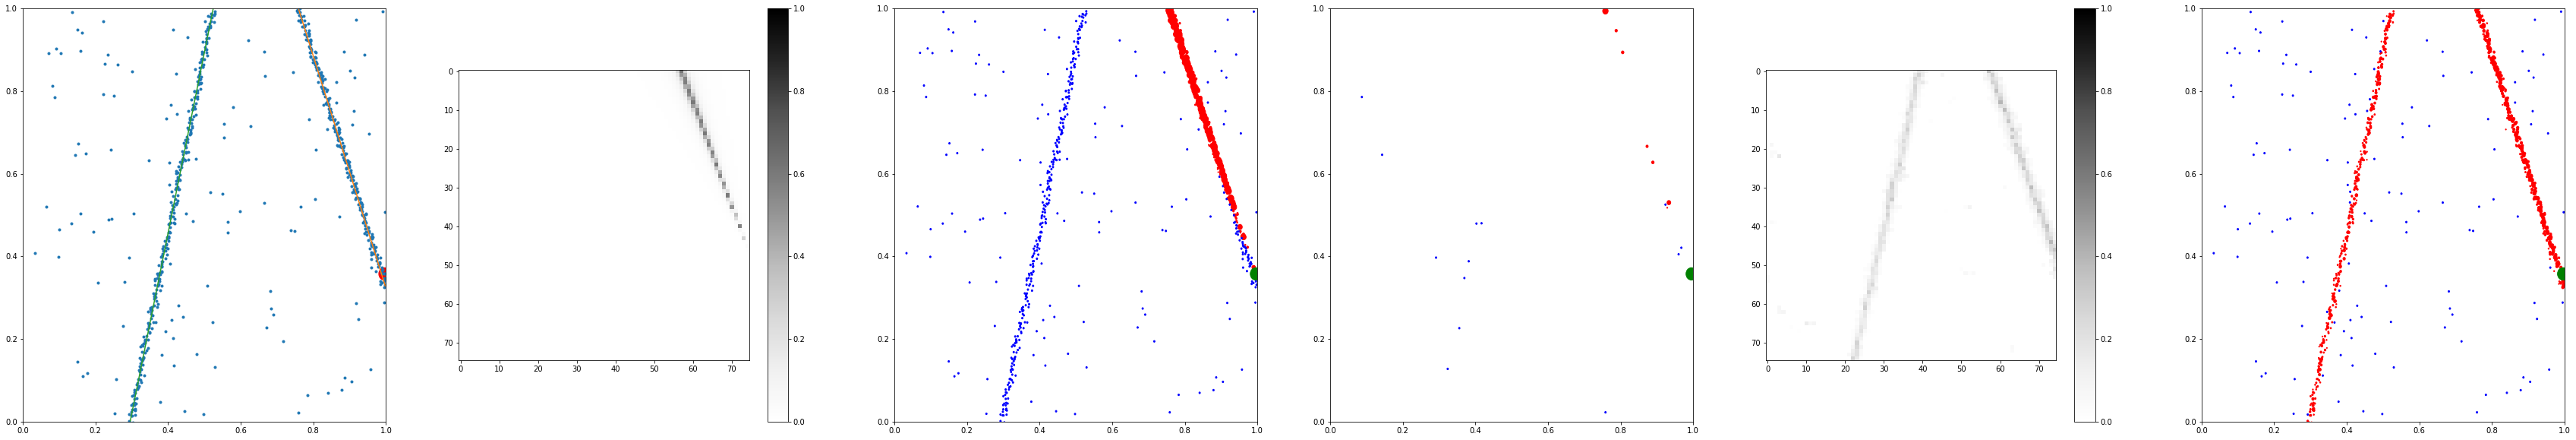

iteration =  1  ; loss_train =  0.009999162830515869  ; loss_eval =  0.008472810685634612
iteration =  2  ; loss_train =  0.010000099418943541  ; loss_eval =  0.008409555256366729
iteration =  3  ; loss_train =  0.010017745293832073  ; loss_eval =  0.008460470288991929
iteration =  4  ; loss_train =  0.009971738402317796  ; loss_eval =  0.00844341591000557
iteration =  5  ; loss_train =  0.009962583055150591  ; loss_eval =  0.008462419360876083
iteration =  6  ; loss_train =  0.009962065025077512  ; loss_eval =  0.00851483941078186
iteration =  7  ; loss_train =  0.009935616335779843  ; loss_eval =  0.008462777733802796
iteration =  8  ; loss_train =  0.009932809941367143  ; loss_eval =  0.008454778790473938
iteration =  9  ; loss_train =  0.009934474430823077  ; loss_eval =  0.008471067994832993
iteration =  10  ; loss_train =  0.00992863740409828  ; loss_eval =  0.008417532593011857
iteration =  11  ; loss_train =  0.009934959959031807  ; loss_eval =  0.008422552049160004
iteration =

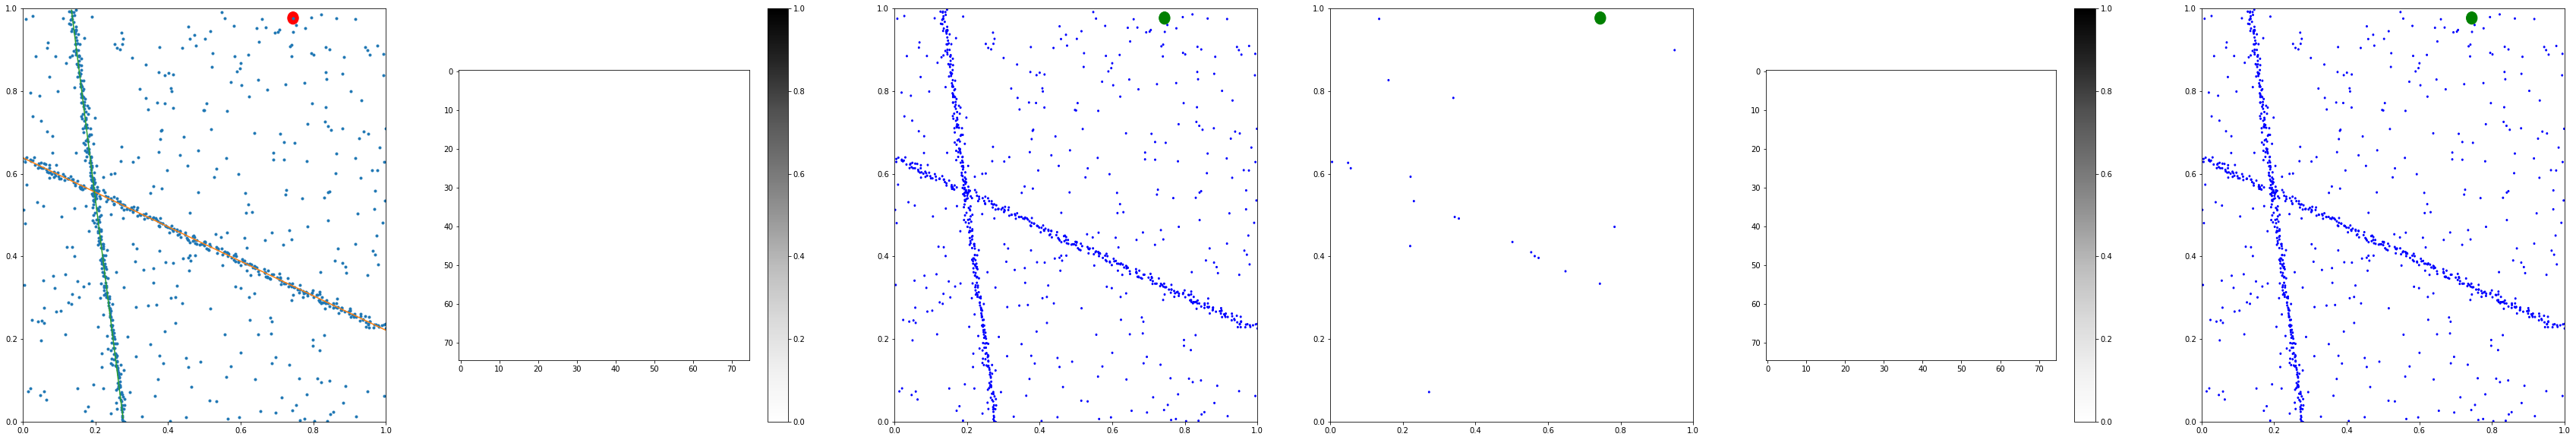

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0196, device='cuda:0')
max/min ref = 0.4255525003480496 0
max/min =  0.4255525003480496 0
mean = 0.08050065957913714
len = 856
max/min =  0.20503540337085724 0
mean = 0.09401849657297134
len = 856
loss_MSE = tensor(0.0196)


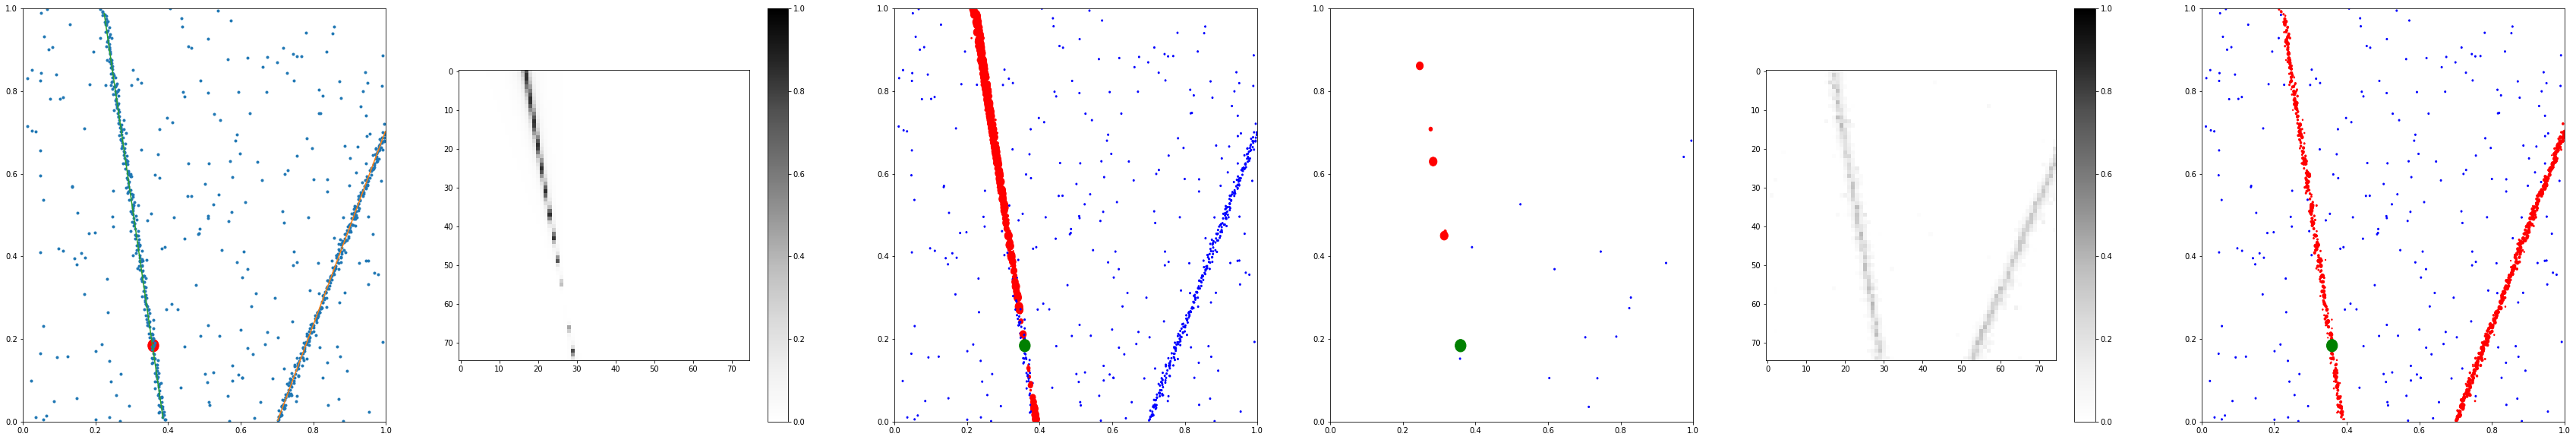

===================== Train ===================
len y in set = 400
loss_norm = tensor(0.0205, device='cuda:0')
max/min ref = 0.44519952773228355 0
max/min =  0.44519952773228355 0
mean = 0.09874702090866806
len = 781
max/min =  0.17453056573867798 0
mean = 0.07653345912694931
len = 781
loss_MSE = tensor(0.0205)


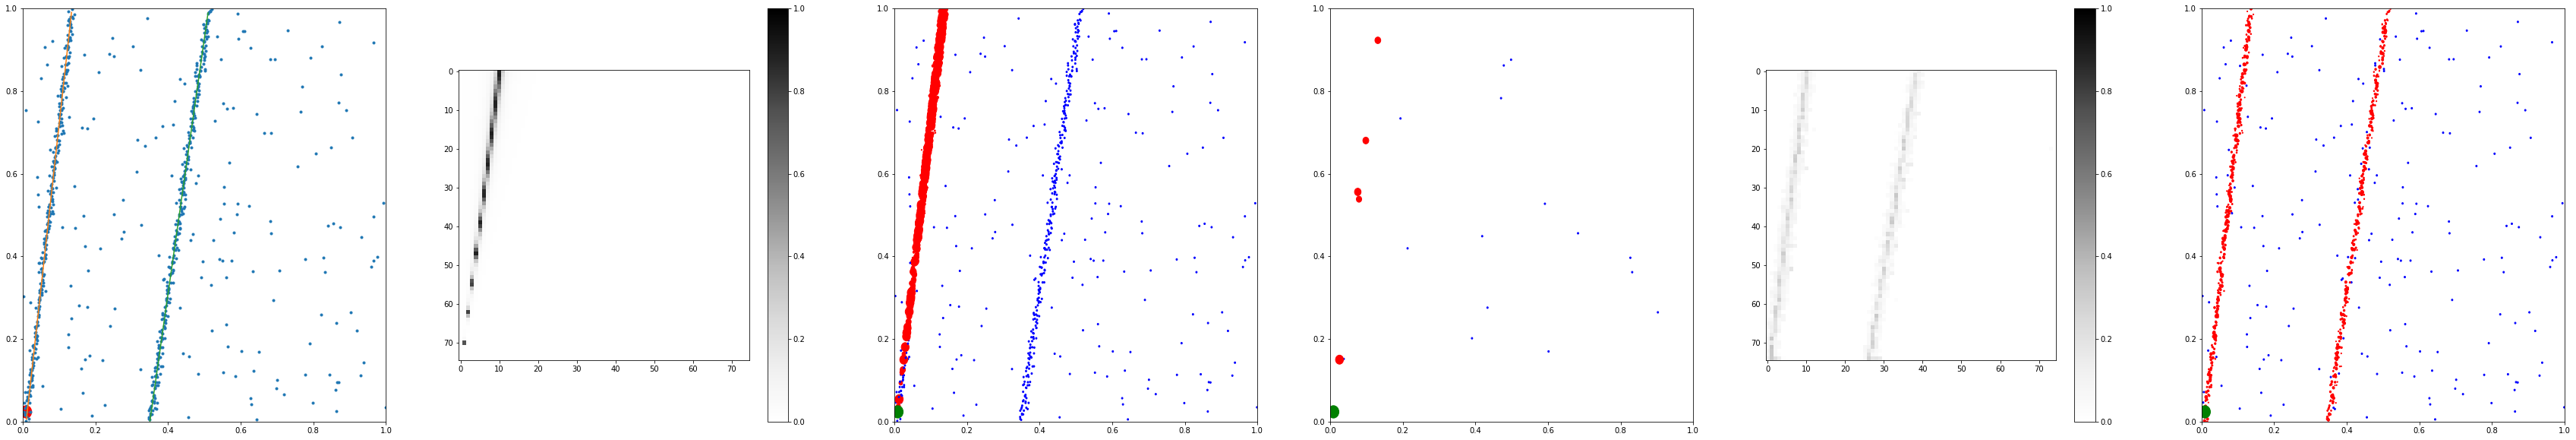

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0144, device='cuda:0')
max/min ref = 0.46198871600133185 0
max/min =  0.46198871600133185 0
mean = 0.0869557549922423
len = 881
max/min =  0.20109379291534424 0.0
mean = 0.06241777539253235
len = 881
loss_MSE = tensor(0.0144)


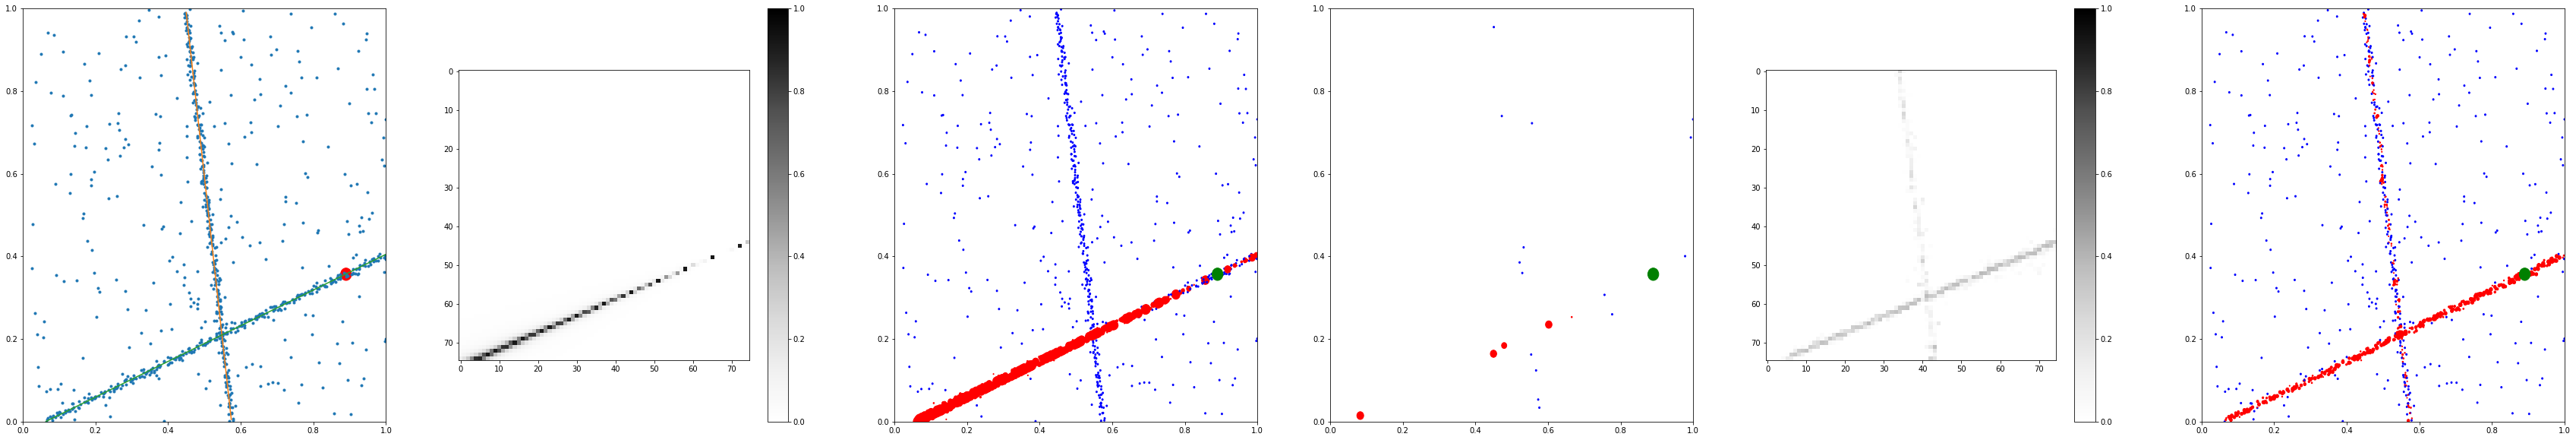

iteration =  201  ; loss_train =  0.009370075907402983  ; loss_eval =  0.008085776865482331
iteration =  202  ; loss_train =  0.009388484759256244  ; loss_eval =  0.008072621375322341
iteration =  203  ; loss_train =  0.009385100326552574  ; loss_eval =  0.008053123950958252
iteration =  204  ; loss_train =  0.009379438722195725  ; loss_eval =  0.0080776184797287
iteration =  205  ; loss_train =  0.009356519321186675  ; loss_eval =  0.007999344915151595
iteration =  206  ; loss_train =  0.009374898426338202  ; loss_eval =  0.008056924492120743
iteration =  207  ; loss_train =  0.009363774390011612  ; loss_eval =  0.008034136146306992
iteration =  208  ; loss_train =  0.009385065257083625  ; loss_eval =  0.008043789863586425
iteration =  209  ; loss_train =  0.009348710099907799  ; loss_eval =  0.008111282438039779
iteration =  210  ; loss_train =  0.009356434440188523  ; loss_eval =  0.008069182932376861
iteration =  211  ; loss_train =  0.009380870719905943  ; loss_eval =  0.008048295

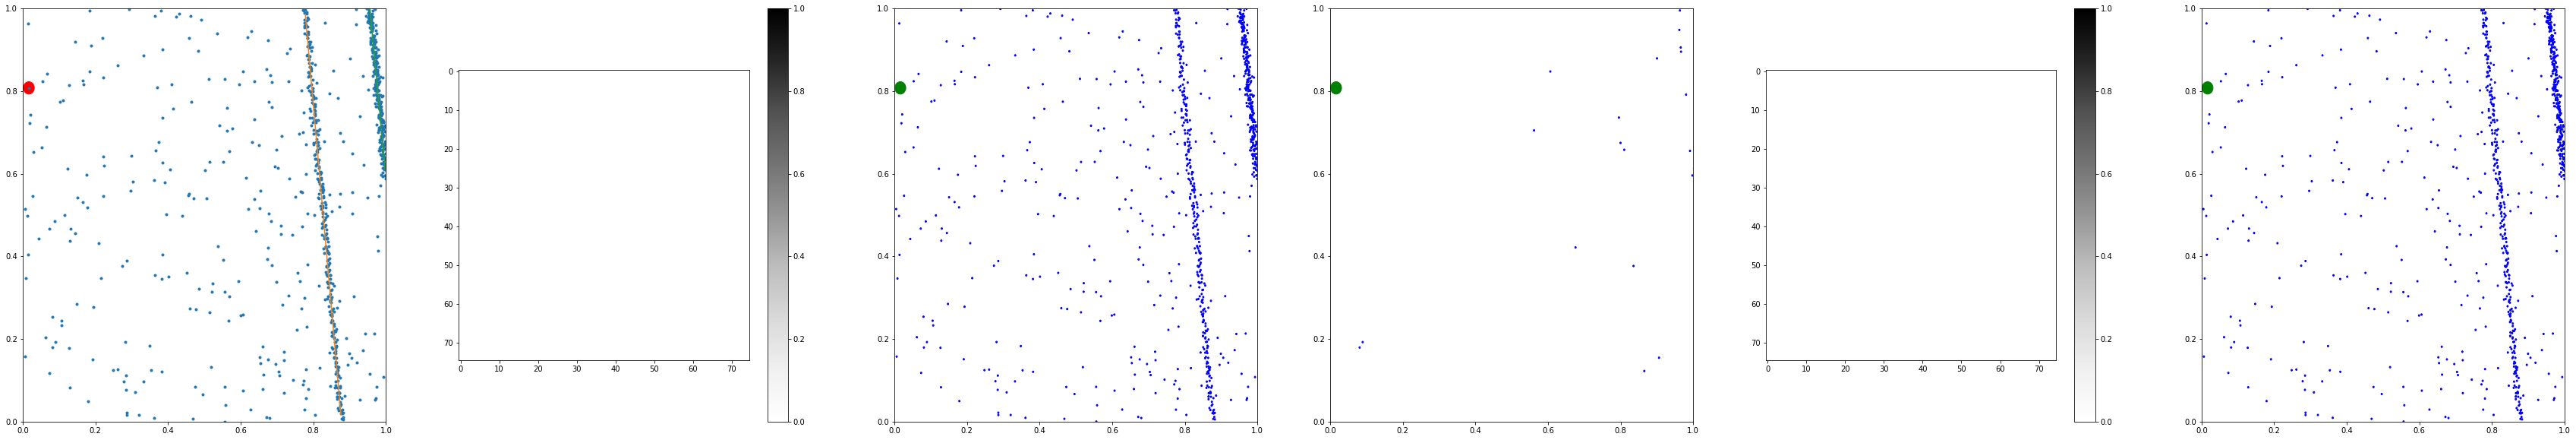

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0064, device='cuda:0')
max/min ref = 0.2808362748598421 0
max/min =  0.2808362748598421 0
mean = 0.0499505844060602
len = 866
max/min =  0.1883649230003357 0
mean = 0.07381772994995117
len = 866
loss_MSE = tensor(0.0064)


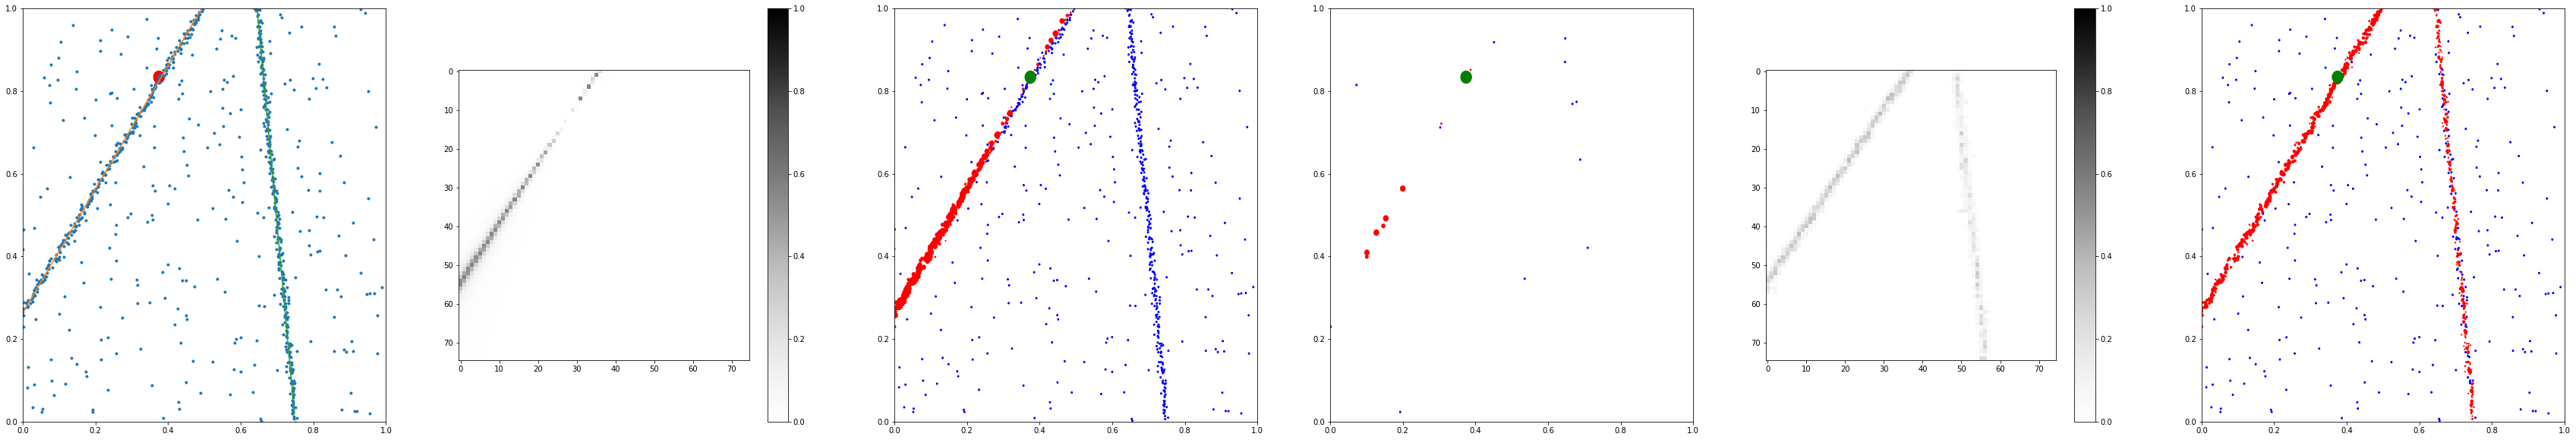

===================== Train ===================
len y in set = 400
loss_norm = tensor(0.0025, device='cuda:0')
max/min ref = 0.15461620727768444 0
max/min =  0.15461620727768444 0
mean = 0.029041603366918273
len = 807
max/min =  0.12596619129180908 0
mean = 0.0521099790930748
len = 807
loss_MSE = tensor(0.0025)


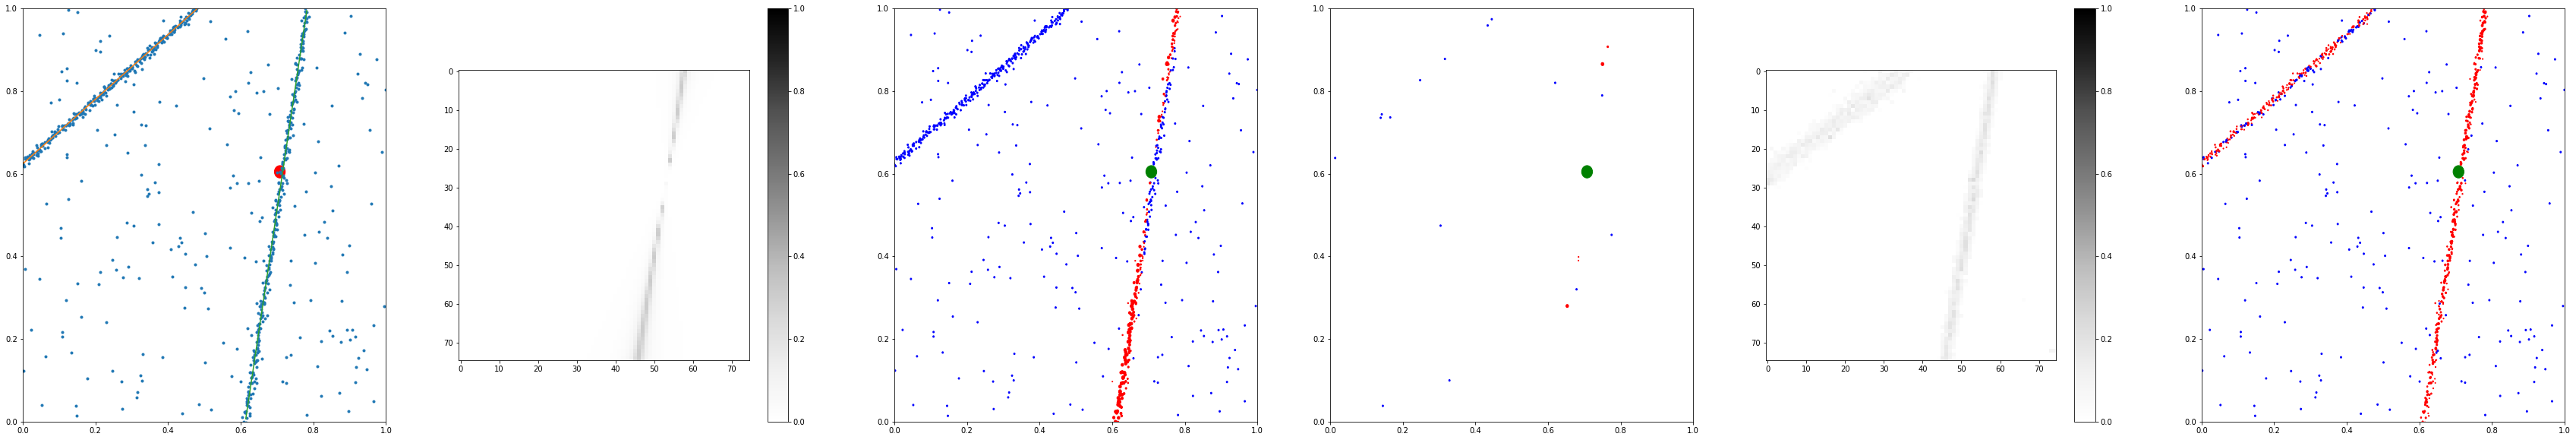

===================== Test ===================
len y in set = 400
loss_norm = tensor(0.0123, device='cuda:0')
max/min ref = 0.4328277399342917 0
max/min =  0.4328277399342917 0
mean = 0.08452864294918645
len = 805
max/min =  0.18020661175251007 0
mean = 0.05483035743236542
len = 805
loss_MSE = tensor(0.0123)


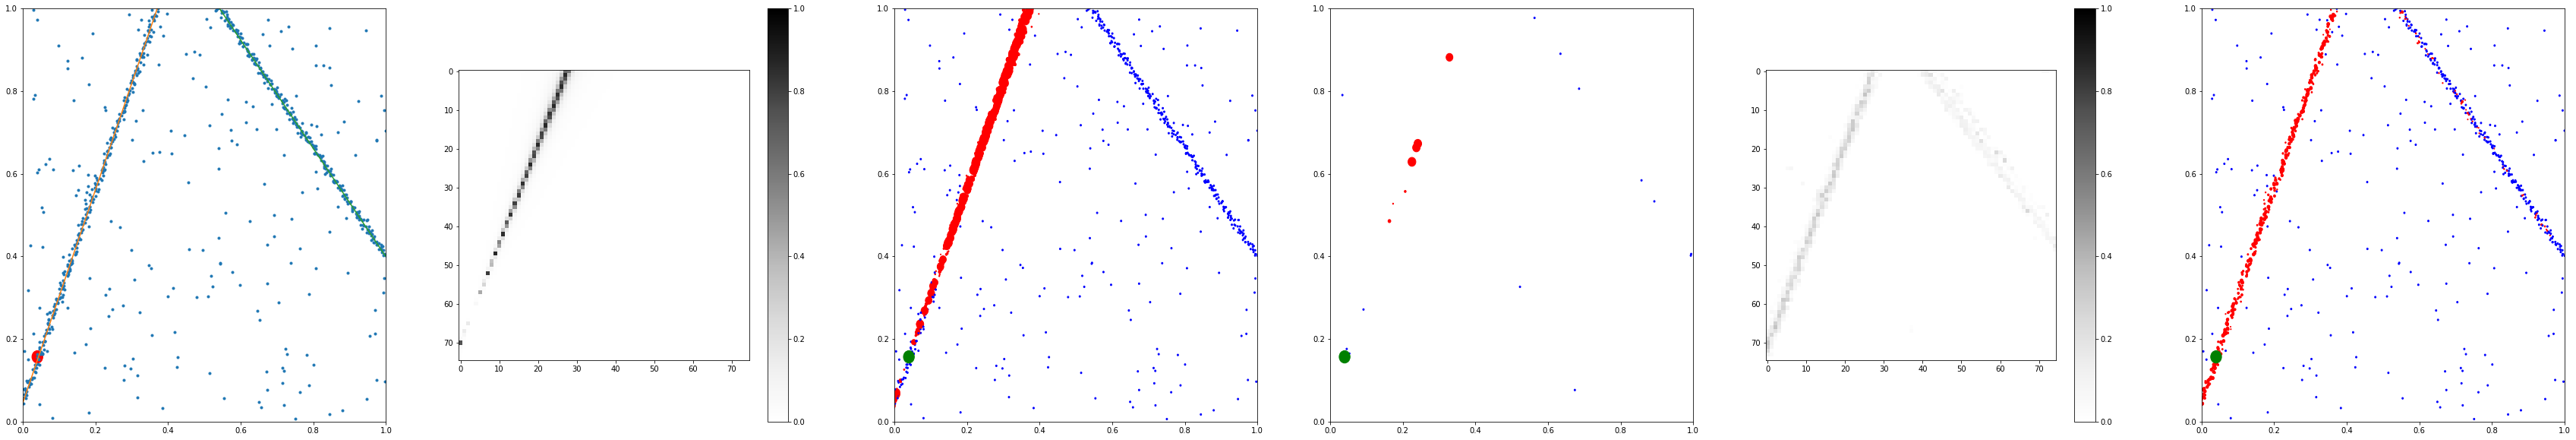

iteration =  401  ; loss_train =  0.008951380786796411  ; loss_eval =  0.00802164375782013
iteration =  402  ; loss_train =  0.008911950408946722  ; loss_eval =  0.00793759822845459
iteration =  403  ; loss_train =  0.00894257254096576  ; loss_eval =  0.007966773211956024
iteration =  404  ; loss_train =  0.00890973239697309  ; loss_eval =  0.00793684795498848
iteration =  405  ; loss_train =  0.008927478163968772  ; loss_eval =  0.007946610450744629
iteration =  406  ; loss_train =  0.008934534206572507  ; loss_eval =  0.007975909858942032
iteration =  407  ; loss_train =  0.008911501080729068  ; loss_eval =  0.007894877344369888
iteration =  408  ; loss_train =  0.008911266036900796  ; loss_eval =  0.007963043451309205
iteration =  409  ; loss_train =  0.008933514637303436  ; loss_eval =  0.007966693490743637
iteration =  410  ; loss_train =  0.008927302669164621  ; loss_eval =  0.007945718616247177
iteration =  411  ; loss_train =  0.008897137180125962  ; loss_eval =  0.008004021644

In [80]:
scale_patch = (0.02, 0.02)
print("start....")
train_model_multi_lines(model_multi, sigma_noise, 300, (20, 20), 500, 300, nbr_inliers, (50, 400), (2, 2), print_test=200, nbr_print=2, lr=10**(-4), print_type=['train', 'test'], scale=75)
print("end")

In [81]:
save_model(model_multi, "model_knn_multi")

In [21]:
model_patch_3D_multi_load = model.Weights3D().to(DEVICE)
load_model(model_patch_3D_multi_load, "model_patch_3D_multi")

In [ ]:
scale_patch = (0.02, 0.02)
plt.figure(1, figsize=(70, 10))
plot_weights_patch_3D(model_patch_3D_multi_load, sigma_noise, (2, 2), nbr_inliers, (200, 200), size_patch, scale_patch, scale=50)

In [ ]:
for _ in range(5):
    scale_patch = (0.02, 0.02)
    plt.figure(1, figsize=(70, 10))
    plot_weights_patch_3D(model_patch_3D_multi_load, sigma_noise, (2,2), nbr_inliers, (50, 400), size_patch, scale_patch, scale=50)
    plt.show()

In [ ]:
for _ in range(5):
    scale_patch = (0.02, 0.02)
    plt.figure(1, figsize=(70, 10))
    plot_weights_patch_multi(model_patch_multi, sigma_noise, (5,5), nbr_inliers, (50, 400), size_patch, scale_patch, scale=50)
    plt.show()

In [83]:
model_multi_load = model.Weights().to(DEVICE)
load_model(model_multi_load, "model_knn_multi")

In [ ]:
for _ in range(10):
    plt.figure(1, figsize=(70, 10))
    plot_weights_knn(model_multi, sigma_noise, (2,2), nbr_inliers, (50, 400), scale=50)
    plt.show()

### Plot weights

In [87]:
def plot_weights_knn(model, sigma, nbr_lines_range, nbr_inliers, nbr_outliers_range, scale=75):
    nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
    lines_ref = []
    for _ in range(nbr_lines):
        line_ref = utils.generate_line()
        lines_ref.append(line_ref)
    n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
    data, index_inliers = utils.generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    i1 = np.random.randint(n)
    dist_ref = utils.dist_ref_multi_line(data, index_inliers, lines_ref)
    p1 = (data[0][i1], data[1][i1])

    weights_predict_train, weights_predict_eval = utils.compute_weights(model, 1, data, i1, train=True)
    weights_ref_points = utils.compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    utils.plot_weights_data(weights_ref_points, data, p1, 163)
    print("-------------weights predict train-----------------")
    utils.plot_weights_data(weights_predict_train, data, p1, 166, item=True)
    print("-------------weights predict eval-----------------")
    utils.plot_weights_data(weights_predict_eval, data, p1, 165, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    all_features = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature=utils.compute_features_k(data, i1, n)
            all_features[scale-i-1][j] = feature
            line = utils.compute_line_from_points(p1, p2)
            area = utils.loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features = list(chain.from_iterable(all_features))
    
    model.eval()
    with torch.no_grad():                
        X_tensor = torch.Tensor(all_features)
        weights = model(X_tensor.to(DEVICE).float())


    utils.plot_first_point_multi(data, lines_ref, p1, 161)
    utils.plot_image(weights_ref, scale, 162)
    utils.plot_image(weights.cpu(), scale, 164)
    

In [88]:
def plot_weights_patch(model, sigma, nbr_inliers, nbr_outliers_range, size_patch, scale_patch, scale=75):
    line_ref = utils.generate_line()
    n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
    data = utils.generate_data(line_ref, sigma, nbr_inliers, n_outliers)
        
    n = len(data[0])
    i1 = np.random.randint(n)
    p1 = (data[0][i1], data[1][i1])


    weights_predict_train, weights_predict_eval = utils.compute_weights(model, 2, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = utils.compute_weights_ref(line_ref, data, i1, 2, n_inliers = nbr_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    utils.plot_weights_data(weights_ref_points, data, p1, 163)
    print("-------------weights predict train-----------------")
    utils.plot_weights_data(weights_predict_train, data, p1, 166, item=True)
    print("-------------weights predict eval-----------------")
    utils.plot_weights_data(weights_predict_eval, data, p1, 165, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())
    
    
    dist_ref = utils.dist_points_to_line(data, line_ref, nbr_inliers)
    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    all_features_patch3 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2, feature3 = utils.compute_features_patch(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            all_features_patch3[scale-i-1][j] = feature3
            line = utils.compute_line_from_points(p1, p2)
            #area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
            area = utils.loss_dist_points_sigmoid(data, line, dist_ref, nbr_inliers)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    all_features_patch3 = list(chain.from_iterable(all_features_patch3))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1)
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        X_tensor_patch3 = torch.Tensor(all_features_patch3)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))


    utils.plot_first_point(data, line_ref, p1, 161)
    utils.plot_image(weights_ref, scale, 162)
    utils.plot_image(weights.cpu(), scale, 164)


In [89]:
def plot_weights_patch_multi(model, sigma, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale_patch, scale=75):
    nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
    lines_ref = []
    for _ in range(nbr_lines):
        line_ref = utils.generate_line()
        lines_ref.append(line_ref)
    n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
    data, index_inliers = utils.generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    i1 = np.random.randint(n)
    dist_ref = utils.dist_ref_multi_line(data, index_inliers, lines_ref)
    p1 = (data[0][i1], data[1][i1])

    weights_predict_train, weights_predict_eval = utils.compute_weights(model, 2, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = utils.compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    utils.plot_weights_data(weights_ref_points, data, p1, 163)
    print("-------------weights predict train-----------------")
    utils.plot_weights_data(weights_predict_train, data, p1, 166, item=True)
    print("-------------weights predict eval-----------------")
    utils.plot_weights_data(weights_predict_eval, data, p1, 165, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    all_features_patch3 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2, feature3=utils.compute_features_patch(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            all_features_patch3[scale-i-1][j] = feature3
            line = utils.compute_line_from_points(p1, p2)
            area = utils.loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    all_features_patch3 = list(chain.from_iterable(all_features_patch3))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1)
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        X_tensor_patch3 = torch.Tensor(all_features_patch3)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))


    utils.plot_first_point_multi(data, lines_ref, p1, 161)
    utils.plot_image(weights_ref, scale, 162)
    utils.plot_image(weights.cpu(), scale, 164)
    

In [90]:
def plot_weights_patch_3D(model, sigma, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale_patch, scale=75):
    nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
    lines_ref = []
    for _ in range(nbr_lines):
        line_ref = utils.generate_line()
        lines_ref.append(line_ref)
    n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
    data, index_inliers = utils.generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    i1 = np.random.randint(n)
    dist_ref = utils.dist_ref_multi_line(data, index_inliers, lines_ref)
    p1 = (data[0][i1], data[1][i1])

    weights_predict_train, weights_predict_eval = utils.compute_weights_patch_3D(model, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = utils.compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    utils.plot_weights_data(weights_ref_points, data, p1, 173)
    print("-------------weights predict train-----------------")
    utils.plot_weights_data(weights_predict_train, data, p1, 177, item=True)
    print("-------------weights predict eval-----------------")
    utils.plot_weights_data(weights_predict_eval, data, p1, 176, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2=utils.compute_features_patch_3D(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            line = utils.compute_line_from_points(p1, p2)
            area = utils.loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1).squeeze()
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float()))
        #weights = model(X_tensor_patch1.to(DEVICE).float())

    utils.plot_first_point_multi(data, lines_ref, p1, 171)
    utils.plot_image(weights_ref, scale, 172)
    utils.plot_patch(i1, data, size_patch, scale_patch, 174)
    utils.plot_image(weights.cpu(), scale, 175)
    

### Ransac

In [91]:
def get_inliers(data, line, threshold):
    a, b = line
    X, Y = data
    Inliers = [[], []]
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        if abs((a*x+b) - y)/sqrt(1+a*a) < threshold:
            Inliers[0].append(x)
            Inliers[1].append(y)
    return Inliers
        

def get_model(model, model_type, data, type_loss, line_ref=None, size_patch=None, scale_patch=None):
    i1 = np.random.randint(len(data[0]))
    if line_ref is None:
        if model_type==3:
            weights = utils.compute_weights_patch_3D(model, data, i1, size_patch=size_patch, scale=scale_patch)
        else:
            weights = utils.compute_weights(model, model_type, data, i1, size_patch=size_patch, scale=scale_patch)
    else:
        if type(line_ref) == 'list':
            weights = utils.compute_weights_ref_multi(line_ref, data, i1, type_loss)
        else:
            weights = utils.compute_weights_ref(line_ref, data, i1, type_loss)
    #print(mean_weights(weights))
    i2 = utils.sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = utils.compute_line_from_points(p1, p2)
    return line


def update_stopping_criterion(k, inliers, proba, it_end):
    if k >= it_end:
        return True
    return False


def ransac(data, threshold, proba, type_loss, model_type = None, line_ref=None, model=None, compare=False, size_patch=None, scale_patch=None, it_end=150):
    print("start ransac with model type", model_type, "weights ref =", (not line_ref is None))
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model(model, model_type, data, type_loss, line_ref, size_patch, scale_patch)
        inliers = get_inliers(data, line, threshold)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
            print("iteration=", k)
            print("nbr_inliers_so_far=", len(inliers_max[0]))
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    print("ransac done")
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

### Uniform Ransac


In [92]:
def get_model_uniform(data):
    n = len(data[0])
    i1 = np.random.randint(n)
    i2 = np.random.randint(n)
    while i1 == i2:
        i2 = np.random.randint(n)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = utils.compute_line_from_points(p1, p2)
    return line


def ransac_uniform(data, threshold, proba, it_end=150):
    print("start uniform ransac...", end='')
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model_uniform(data)
        inliers = get_inliers(data, line, threshold)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba, it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    print("done")
    return line_max, inliers_max, nbr_inliers

### Compare Ransacs

In [155]:
def compare_to_uniform(sigma, n_inliers, n_outliers, type_loss, model=None, model_type=None, size_patch=None, scale_patch = None, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = utils.generate_line()
        data = utils.generate_data(line, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 0.01
    proba = 0.1
    
    it = 20
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        print(k)
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, proba, type_loss, model_type=model_type, line_ref=None, model=model, compare=True, size_patch=size_patch, scale_patch=scale_patch, it_end=it)
        line_predict2, inliers2, nbr_inliers2 = ransac_uniform(Datas[k], threshold, proba, it_end=it)
        utils.plot_lines_bis(Datas[k], line_predict1, line_predict2)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_uniform, c='r')
    fig.show()
    
    print("done")

def compare_all_ransac(sigma, models, n_inliers, n_outliers, size_patch=None, scale_patch=None, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = utils.generate_line()
        data = utils.generate_data(line, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 0.01
    proba = 0.1
    
    it = 10
    n_types = len(models)
    nbr_inliers_all = [[0]*it for _ in range(n_types+1)]
    colors = ['black', 'green', 'red', 'yellow', 'orange', 'blue']
    labels=[""]*(n_types+1)
    
    for k in range(average):
        print(k)
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        data = Datas[k]
        utils.plot_data(data, ax)
        for j in range(n_types):
            (model, model_type, type_loss, ref, name) = models[j]
            if ref:
                line_ref=Lines[k]
            else:
                line_ref=None
            line_predict, inliers, nbr_inliers = ransac(data, threshold, proba, type_loss, model_type = model_type, line_ref=line_ref, model=model, compare=True, size_patch=size_patch, scale_patch=scale_patch, it_end=it)
            utils.plot_line(line_predict, ax, c=colors[j%len(colors)])
            labels[j] = name

            for i in range(it):
                nbr_inliers_all[j][i] += nbr_inliers[i]
                
        
        line_predict_uni, inliers_unie, nbr_inliers_uni = ransac_uniform(data, threshold, proba, it_end=it)
        utils.plot_line(line_predict_uni, ax, c=colors[n_types%len(colors)])
        for i in range(it):
            nbr_inliers_all[-1][i] += nbr_inliers_uni[i]
        labels[-1] = "uniform"

    
    for j in range(n_types+1):
        for i in range(it):
            nbr_inliers_all[j][i] /=average
        
    fig2, ax2 = plt.subplots()
    for j in range(n_types+1):
        ax2.plot(nbr_inliers_all[j], c=colors[j%len(colors)], label=labels[j])
    ax2.legend()
    plt.xlabel('iteration')
    plt.ylabel('number of inliers')
    fig2.show()
    
    print("done")


In [ ]:
print("nbr_inliers=", nbr_inliers)
print("nbr_outliers=", nbr_outliers)
compare_to_uniform(sigma_noise, nbr_inliers, nbr_outliers, type_loss=2, model=model_patch_3D_multi_load, model_type=3, average=5)


0
start ransac with model type 3 weights ref = False
iteration= 0
nbr_inliers_so_far= 280
ransac done
start ransac with model type 2 weights ref = False
iteration= 0
nbr_inliers_so_far= 228
iteration= 1
nbr_inliers_so_far= 287
ransac done
start ransac with model type 1 weights ref = False
iteration= 0
nbr_inliers_so_far= 211
iteration= 3
nbr_inliers_so_far= 294
ransac done
start uniform ransac...done
1
start ransac with model type 3 weights ref = False
iteration= 0
nbr_inliers_so_far= 264
iteration= 1
nbr_inliers_so_far= 279
iteration= 2
nbr_inliers_so_far= 289
ransac done
start ransac with model type 2 weights ref = False
iteration= 0
nbr_inliers_so_far= 94
iteration= 2
nbr_inliers_so_far= 135
iteration= 3
nbr_inliers_so_far= 285
ransac done
start ransac with model type 1 weights ref = False
iteration= 0
nbr_inliers_so_far= 275
iteration= 2
nbr_inliers_so_far= 289
ransac done
start uniform ransac...done
2
start ransac with model type 3 weights ref = False
iteration= 0
nbr_inliers_so_f

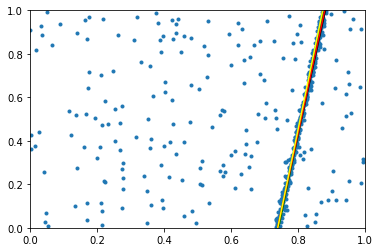

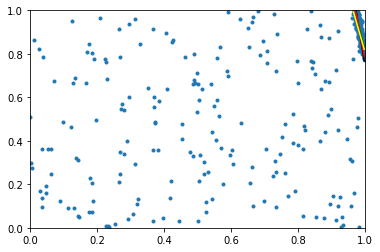

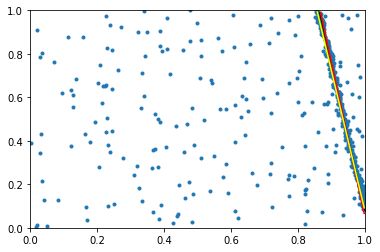

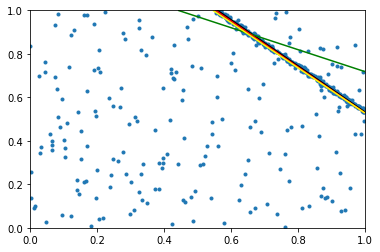

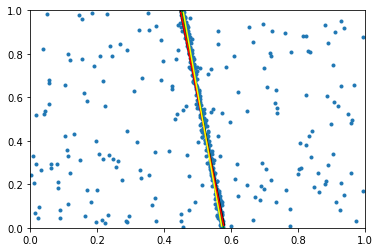

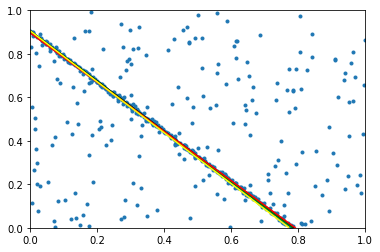

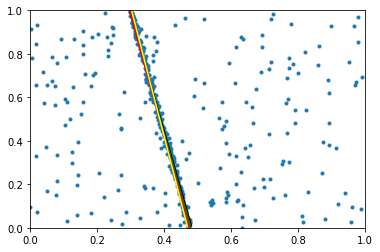

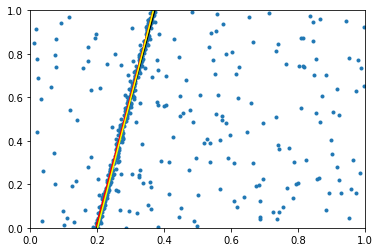

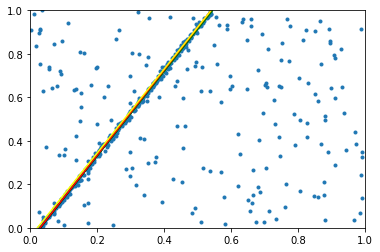

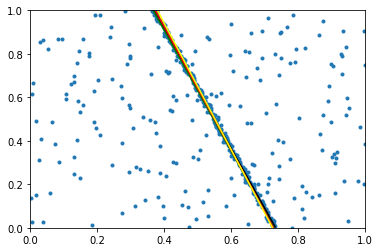

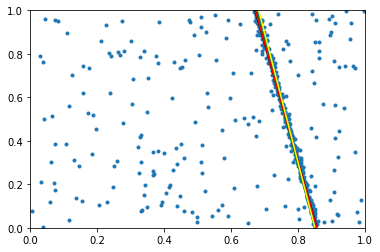

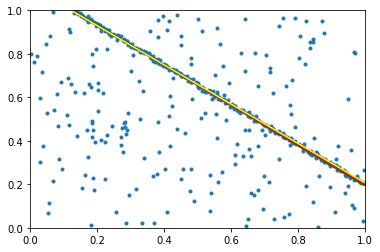

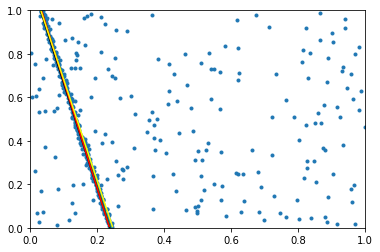

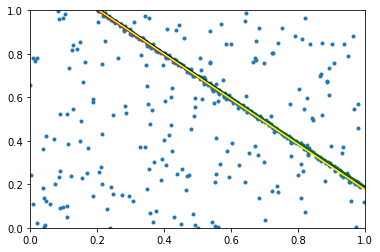

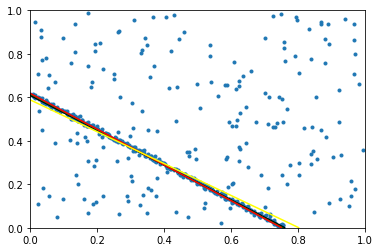

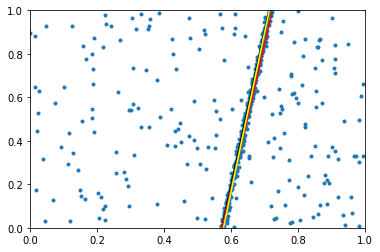

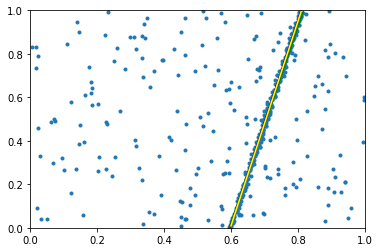

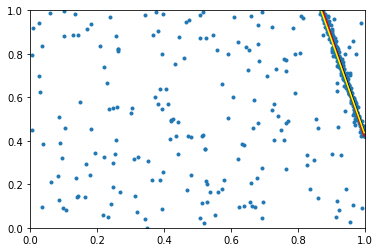

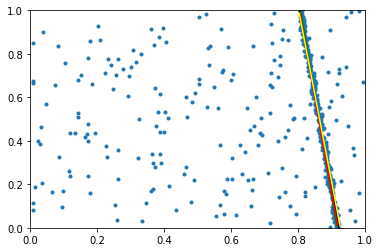

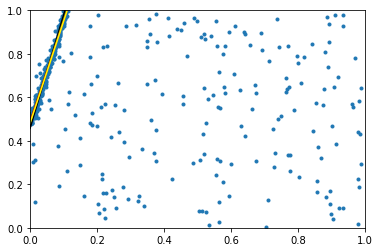

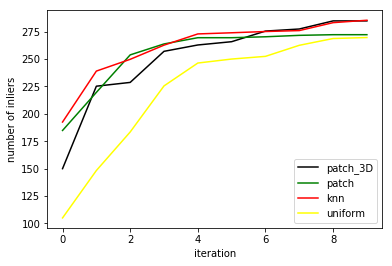

In [156]:
all_models = [(model_patch_3D_multi, 3, 2, False, "patch_3D"), (model_patch_multi, 2, 2, False, "patch"), (model_multi, 1, 2, False, "knn")]
compare_all_ransac(sigma_noise, all_models, nbr_inliers, nbr_outliers, size_patch=size_patch, scale_patch=scale_patch, average=20)

## Multiples Lines

In [141]:
def get_inliers_couple(data, line, threshold):
    a, b = line
    X, Y = data
    Inliers = []
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        if abs((a*x+b) - y)/sqrt(1+a*a) < threshold:
            Inliers.append((x, y))
    return Inliers

def stopping_criterion_multi(step, inliers, total, proba, it_end):
    if step < it_end:
        return False
    return True
    
    #end = True
    #for n_inliers in inliers:
    #    x = 1 - (n_inliers/total)**2
    #    if x**step > proba:
    #        end = False
    return end

def remove_intersection(data, inliers):
    data_update_X = []
    data_update_Y = []
    n = len(data[0])
    for j in range(n):
        (x, y) = data[0][j], data[1][j]
        if (x, y) not in inliers:
            data_update_X.append(x)
            data_update_Y.append(y)
    return (data_update_X, data_update_Y)

#### Uniform v1


In [142]:
def ransac_uniform_multi_v1(data, threshold, threshold_nbr_inliers, proba, it_end=150, compare=False):
    print("strat ransac uniform...", end="")
    inliers_max_all = []
    nbr_inliers_max_all = []
    line_max_all = []
    nbr_inliers = []
    data_update = data
    finish = False
    nbr_inliers = []
    nbr_inliers_removed = 0
    
    while not finish:
        step = 0
        line_max = -1
        nbr_inliers_max = threshold_nbr_inliers
        end = False
        inliers_max = []
        n = len(data_update[0])
        while not end:
            line = get_model_uniform(data_update)
            inliers = get_inliers_couple(data_update, line, threshold)
            if len(inliers) > nbr_inliers_max:
                line_max = line
                nbr_inliers_max = len(inliers)
                inliers_max = inliers
                print("line=", len(line_max_all), "iteration=", step)
                print("nbr_inliers_so_far=", len(inliers_max[0]))
            step += 1
            end = stopping_criterion_multi(step, nbr_inliers_max, n, proba, it_end)
            nbr_inliers.append(nbr_inliers_removed+len(inliers_max))
            
        if line_max == -1:
            finish = True
        else:
            inliers_max_all.append(inliers_max)
            nbr_inliers_max_all.append(nbr_inliers_max)
            line_max_all.append(line_max)
            nbr_inliers_removed += len(inliers_max)
            data_update = remove_intersection(data_update, inliers_max)
            

        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    print("done")
    if compare:
        return line_max_all, inliers_max_all, nbr_inliers_max_all, nbr_inliers
    return line_max_all, inliers_max_all, nbr_inliers_max_all

#### Uniform v2

In [143]:
def ransac_uniform_multi_v2(data, threshold, threshold_nbr_inliers, threshold_intersection, proba):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    it_end=200
    
    while not end:
        if (step % 1000 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model_uniform(data)
        inliers = get_inliers_couple(data, line, threshold)
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                #print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

#### Improved Ransac v1


In [144]:
def ransac_multi_improved_v1(data, threshold, threshold_nbr_inliers, proba, type_loss, model_type = None, line_ref=None, model=None, size_patch=None, scale_patch=None, it_end=150, compare=False):
    print("start ransac with model type", model_type, "weights ref =", (not line_ref is None))
    inliers_max_all = []
    nbr_inliers_max_all = []
    line_max_all = []
    nbr_inliers = []
    data_update = data
    finish = False
    nbr_inliers = []
    nbr_inliers_removed = 0

    while not finish:
        step = 0
        line_max = -1
        nbr_inliers_max = threshold_nbr_inliers
        end = False
        inliers_max = []
        n = len(data_update[0])
        while not end:
            line = get_model(model, model_type, data_update, type_loss, line_ref, size_patch, scale_patch)
            inliers = get_inliers_couple(data_update, line, threshold)
            if len(inliers) > nbr_inliers_max:
                line_max = line
                nbr_inliers_max = len(inliers)
                inliers_max = inliers
                print("iteration=", step)
                print("nbr lines so far=", len(line_max_all))
                print("inliers removed so far=", nbr_inliers_removed)
                print("nbr inliers total so far=", nbr_inliers_removed+nbr_inliers_max)
            step += 1
            end = (step > it_end)
            nbr_inliers.append(nbr_inliers_removed+len(inliers_max))

            
        if line_max == -1:
            finish = True
        else:
            inliers_max_all.append(inliers_max)
            nbr_inliers_max_all.append(nbr_inliers_max)
            line_max_all.append(line_max)
            nbr_inliers_removed += len(inliers_max)
            data_update = remove_intersection(data_update, inliers_max)
            

        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    if compare:
        return line_max_all, inliers_max_all, nbr_inliers_max_all, nbr_inliers
    return line_max_all, inliers_max_all, nbr_inliers_max_all

#### Improved Ransac v2


In [145]:
def ransac_multi_improved_v2(data, threshold, threshold_nbr_inliers, threshold_intersection, proba, type_loss, model_type = None, line_ref=None, model=None, compare=False, size_patch=None, scale_patch=None, it_end=150):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    while not end:
        if (step % 10 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model(model, model_type, data, type_loss, line_ref, size_patch, scale_patch)
        inliers = get_inliers_couple(data, line, threshold)
        print(len(inliers))
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection*len(inliers) - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        #end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        end = (step > it_end)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers_max

#### Compare Ransac

In [153]:
def compare_to_uniform_multi(sigma, n_inliers, n_outliers, nbr_lines_range, type_loss, model=None, model_type=None, size_patch=None, scale_patch = None, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = utils.generate_line()
            lines_ref.append(line_ref)
        data, index_inliers = utils.generate_data_multi_lines(lines_ref, sigma, n_inliers, n_outliers)
        Lines.append(lines_ref)
        Datas.append(data)
    
    threshold = 0.01
    threshold_nbr_inliers = 150
    proba = 0.1
    
    it = 20
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        print(k)
        line_predict1, inliers1, nbr_inliers_max1, nbr_inliers1 = ransac_multi_improved_v1(Datas[k], threshold, threshold_nbr_inliers, proba, type_loss, model_type = model_type, line_ref=None, model=model, size_patch=size_patch, scale_patch=scale_patch, it_end=it, compare=True)
        line_predict2, inliers2, nbr_inliers_max2, nbr_inliers2 =  ransac_uniform_multi_v1(Datas[k], threshold, threshold_nbr_inliers, proba, it_end=it, compare=True)
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        utils.plot_data(Datas[k], ax)
        utils.plot_lines(line_predict1, ax)
        fig1.show()
        fig2, ax2 = plt.subplots()
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        utils.plot_data(Datas[k], ax2)
        utils.plot_lines(line_predict2, ax2)
        fig2.show()
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig3, ax3 = plt.subplots()
    ax3.plot(nbr_inliers_sample, c='g')
    ax3.plot(nbr_inliers_uniform, c='r')
    fig3.show()
    
    print("done")

def compare_all_ransac_multi(sigma, models, n_inliers, n_outliers, nbr_lines_range, size_patch=None, scale_patch=None, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = utils.generate_line()
            lines_ref.append(line_ref)
        data, index_inliers = utils.generate_data_multi_lines(lines_ref, sigma, n_inliers, n_outliers)
        Lines.append(lines_ref)
        Datas.append(data)
    
    threshold = 0.01    
    threshold_nbr_inliers = 150
    proba = 0.1
    
    it = 10
    n_types = len(models)
    nbr_inliers_all = [[0]*it for _ in range(n_types+1)]
    colors = ['black', 'green', 'red', 'yellow', 'orange', 'blue']
    labels = [""]*(n_types+1)
    
    for k in range(average):
        print(k)
        #fig, ax = plt.subplots()
        #ax.set_xlim(0, 1)
        #ax.set_ylim(0, 1)
        data = Datas[k]
        #utils.plot_data(data, ax)
        for j in range(n_types):
            (model, model_type, type_loss, ref, name) = models[j]
            if ref:
                line_ref=Lines[k]
            else:
                line_ref=None
            line_predict, inliers, nbr_inliers_max, nbr_inliers = ransac_multi_improved_v1(data, threshold, threshold_nbr_inliers, proba, type_loss, model_type = model_type, line_ref=line_ref, model=model, size_patch=size_patch, scale_patch=scale_patch, it_end=it, compare=True)
            fig, ax = plt.subplots()
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            utils.plot_data(data, ax)
            utils.plot_lines(line_predict, ax, c=colors[j%len(colors)])
            plt.title(name)
            fig.show()
            labels[j] = name

            for i in range(it):
                nbr_inliers_all[j][i] += nbr_inliers[i]
            labels[-1] = "uniform"
        
        line_predict_uni, inliers_unie, nbr_inliers_max_uni, nbr_inliers_uni = ransac_uniform_multi_v1(data, threshold, threshold_nbr_inliers, proba, it_end=it, compare=True)
        fig, ax = plt.subplots()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        utils.plot_data(data, ax)
        utils.plot_lines(line_predict_uni, ax, c=colors[j%len(colors)])
        plt.title("uniform")
        fig.show()
        
        for i in range(it):
            nbr_inliers_all[-1][i] += nbr_inliers_uni[i]

    
    for j in range(n_types+1):
        for i in range(it):
            nbr_inliers_all[j][i] /=average
        
    fig2, ax2 = plt.subplots()
    for j in range(n_types+1):
        ax2.plot(nbr_inliers_all[j], c=colors[j%len(colors)], label=labels[j])
    ax2.legend()
    plt.xlabel('iteration')
    plt.ylabel('number of inliers')
    fig2.show()
    
    print("done")


0
start ransac with model type 3 weights ref = False
iteration= 1
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 272
iteration= 6
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 276
iteration= 9
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 282
iteration= 0
nbr lines so far= 1
inliers removed so far= 282
nbr inliers total so far= 503
iteration= 1
nbr lines so far= 1
inliers removed so far= 282
nbr inliers total so far= 515
iteration= 4
nbr lines so far= 1
inliers removed so far= 282
nbr inliers total so far= 545
start ransac with model type 2 weights ref = False
iteration= 1
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 274
iteration= 6
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 288
iteration= 2
nbr lines so far= 1
inliers removed so far= 288
nbr inliers total so far= 489
iteration= 10
nbr lines so far= 1
inliers removed so far= 288
nbr inliers total so far=

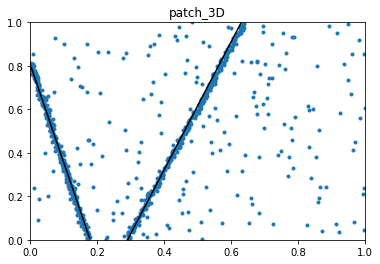

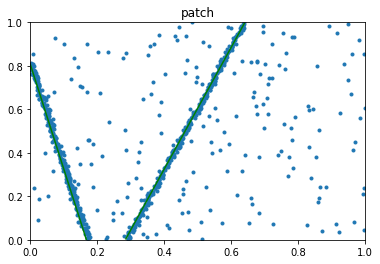

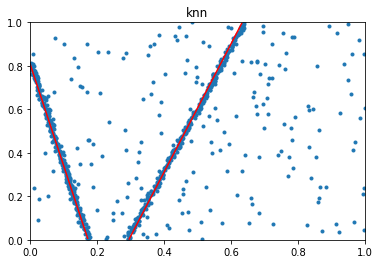

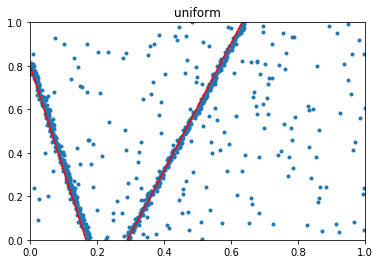

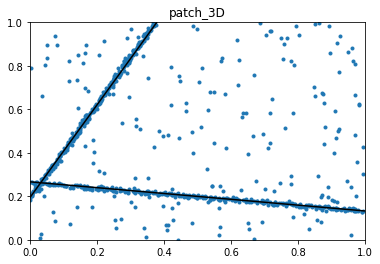

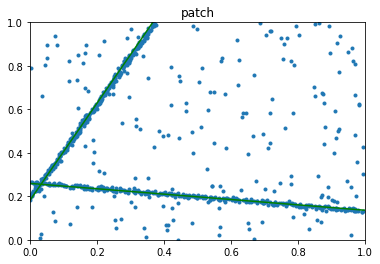

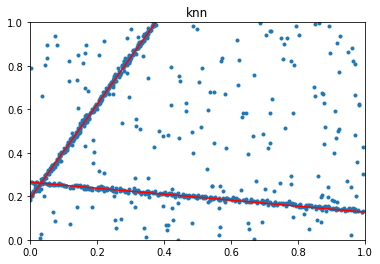

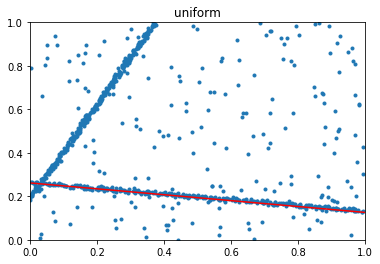

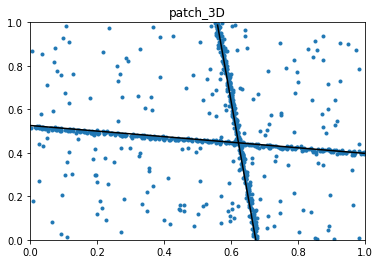

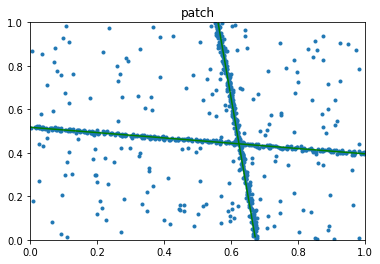

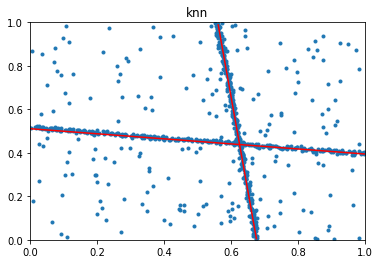

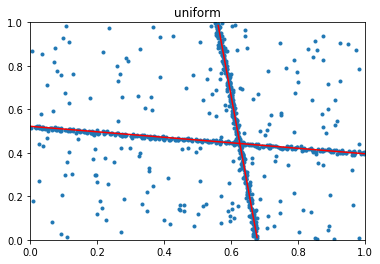

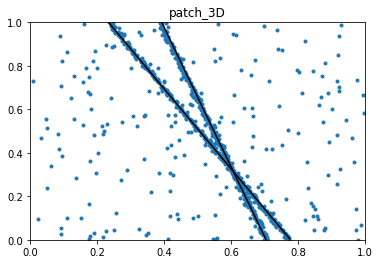

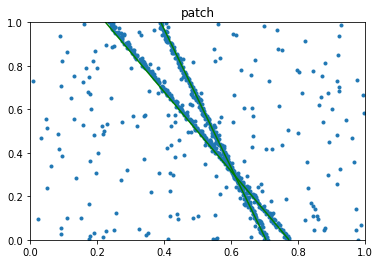

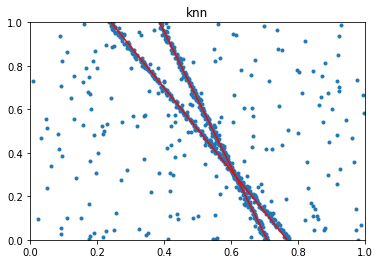

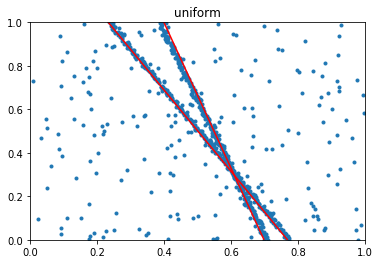

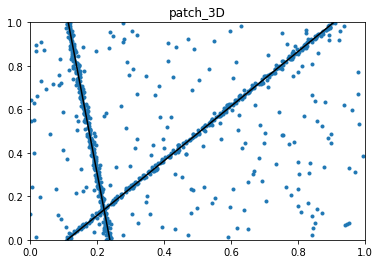

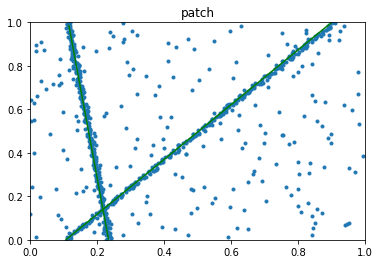

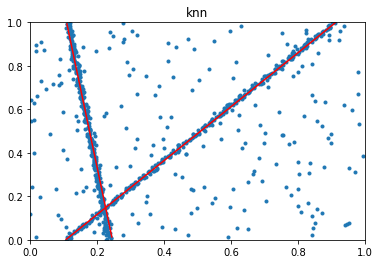

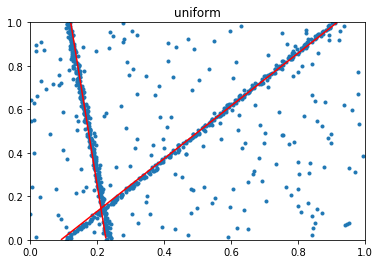

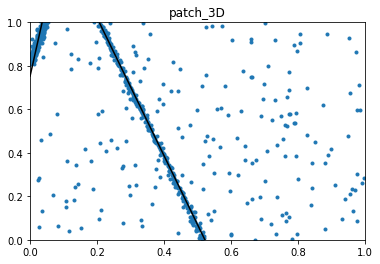

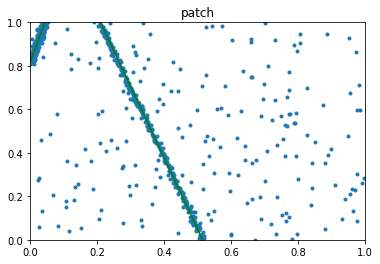

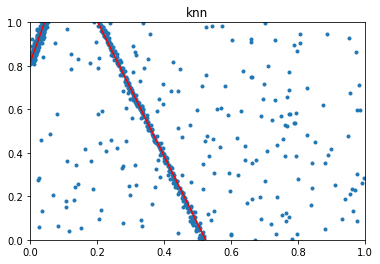

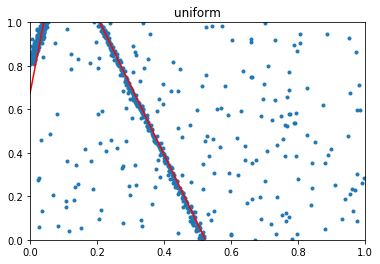

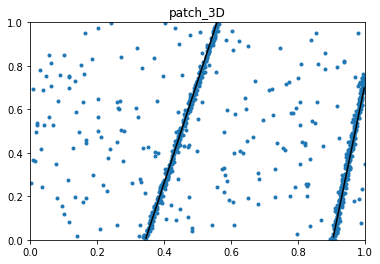

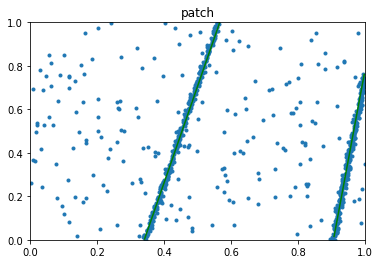

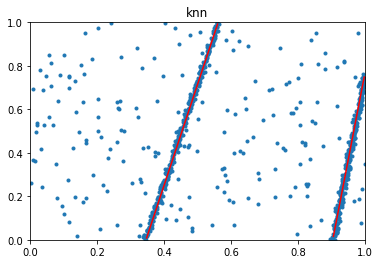

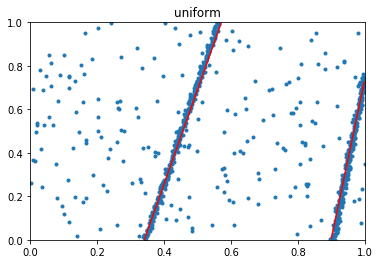

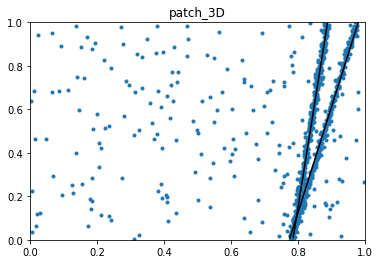

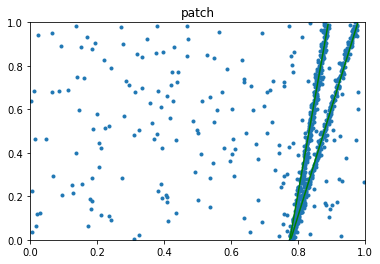

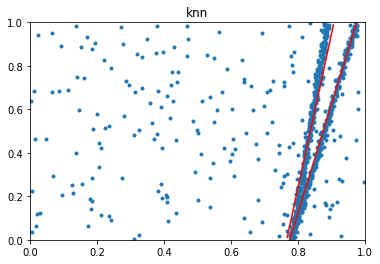

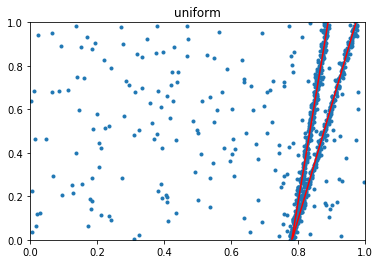

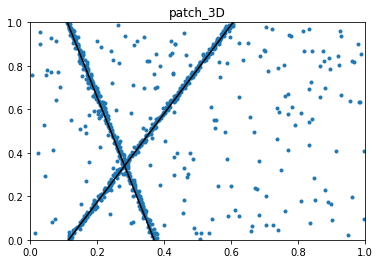

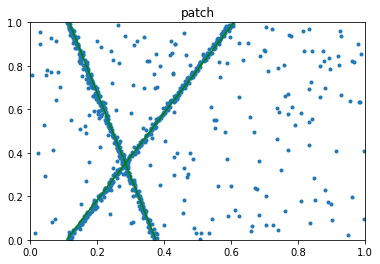

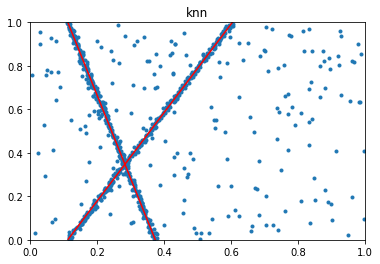

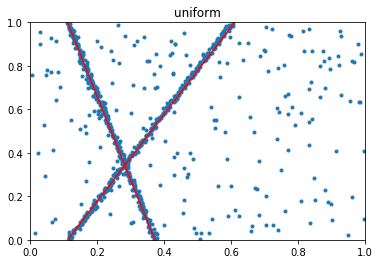

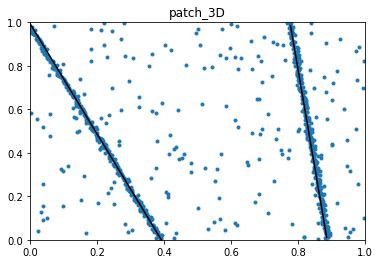

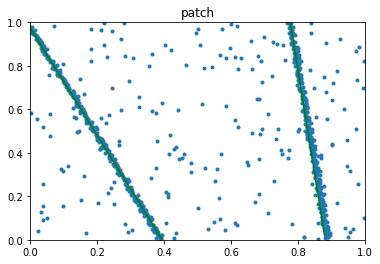

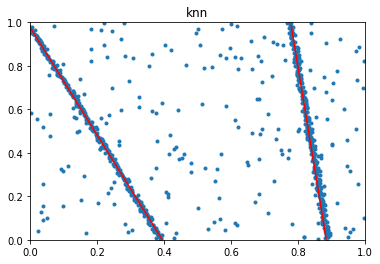

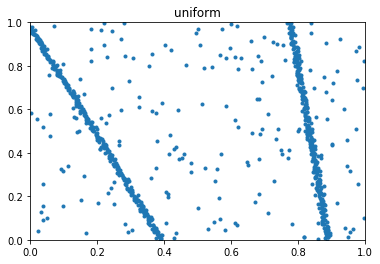

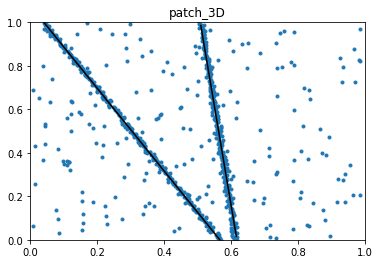

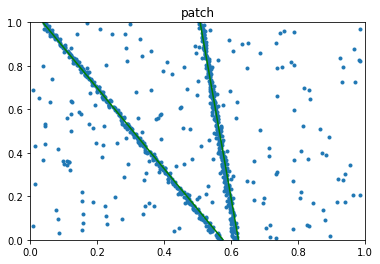

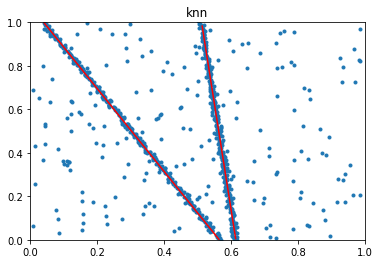

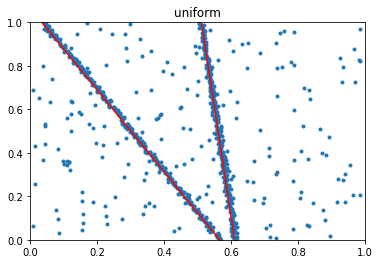

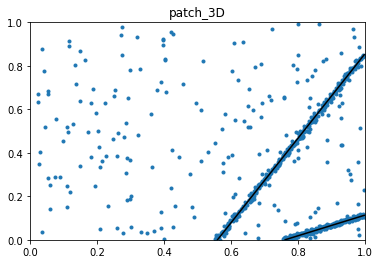

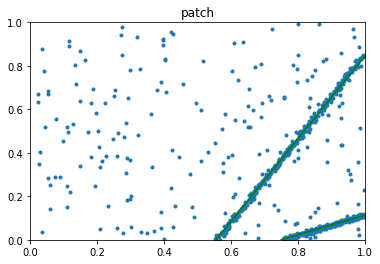

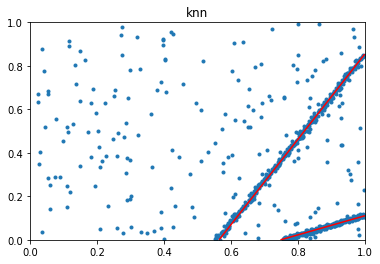

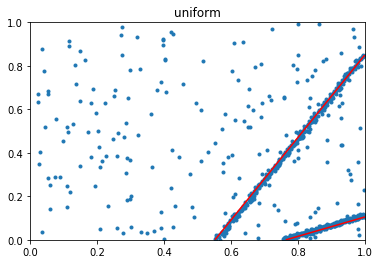

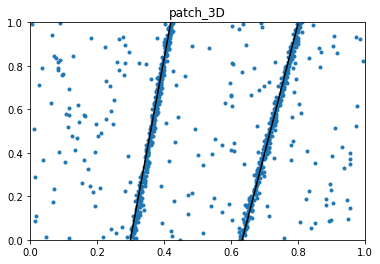

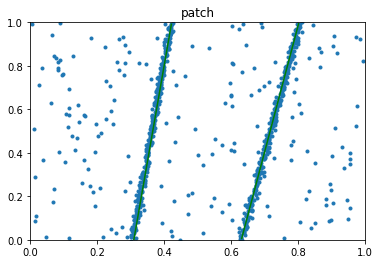

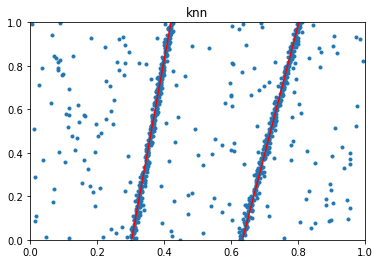

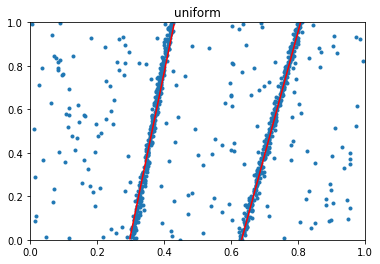

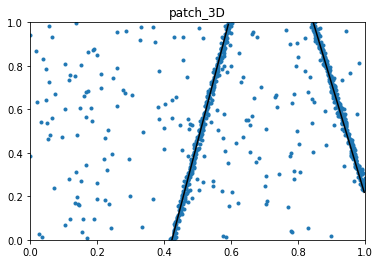

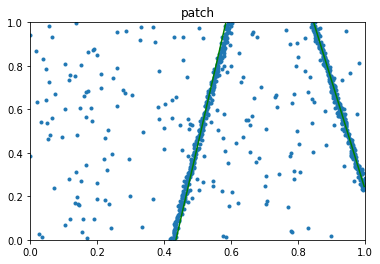

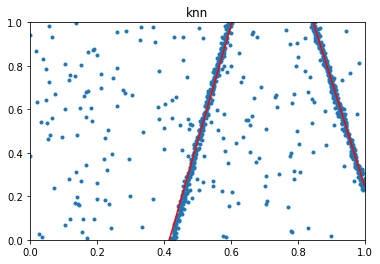

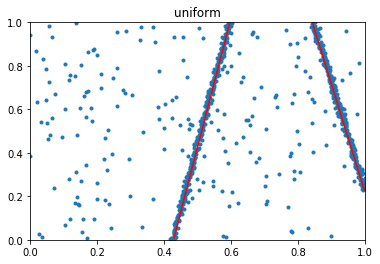

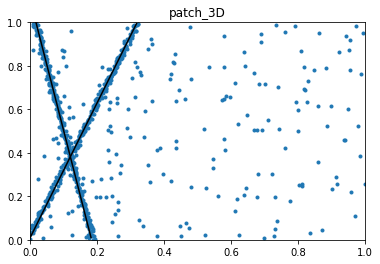

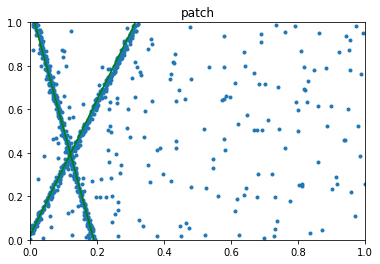

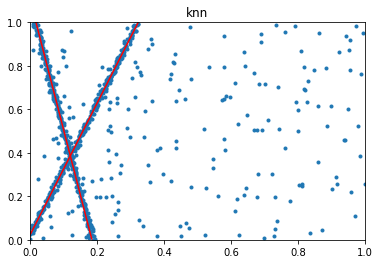

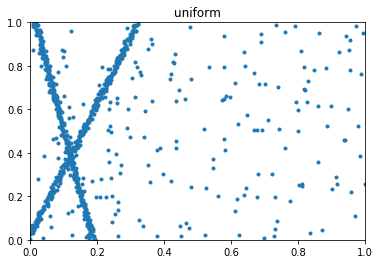

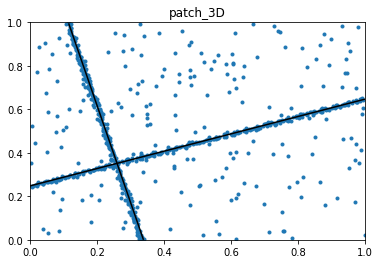

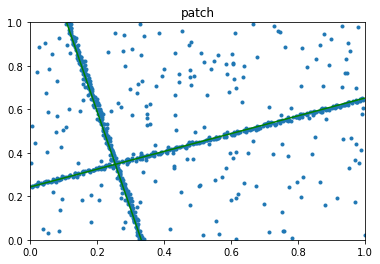

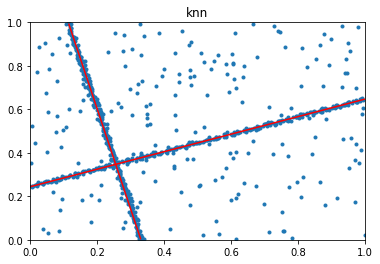

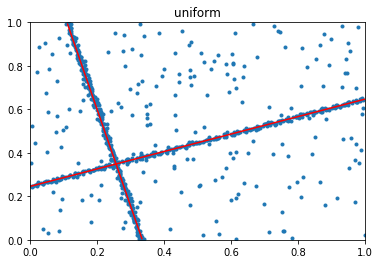

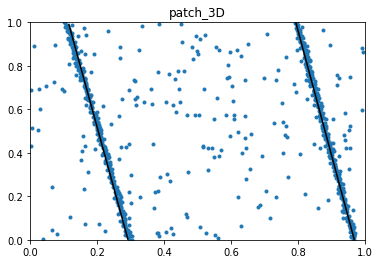

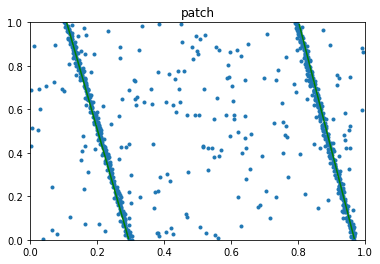

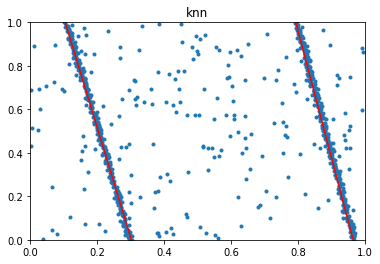

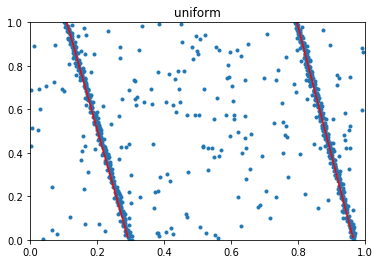

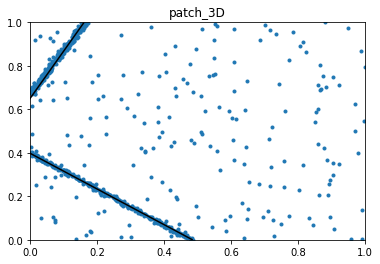

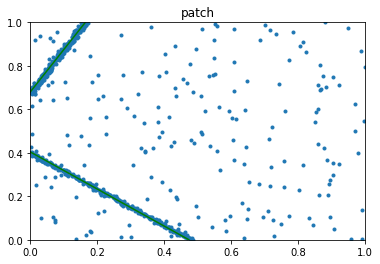

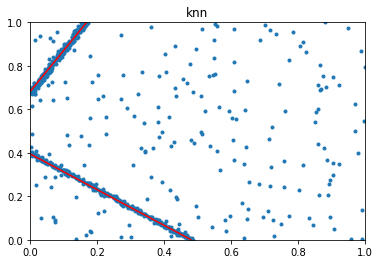

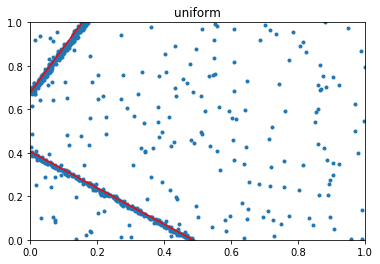

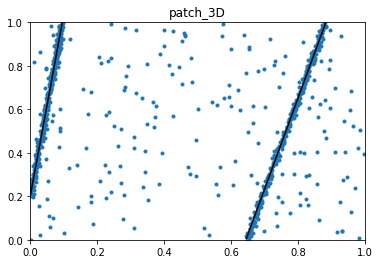

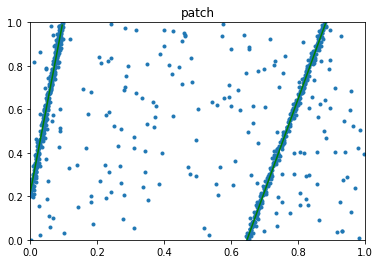

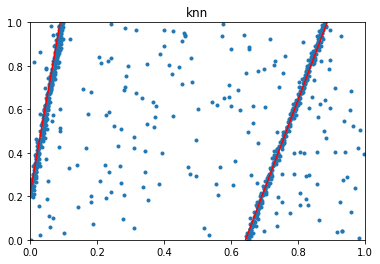

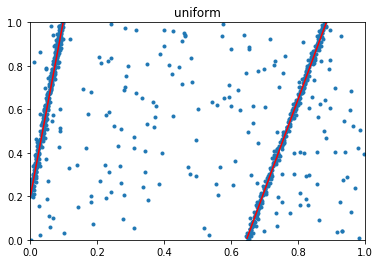

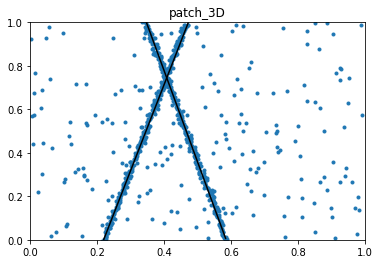

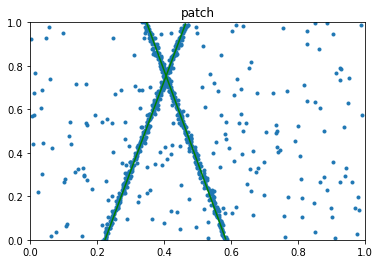

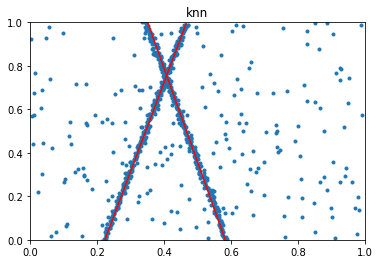

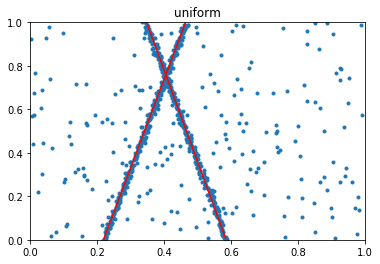

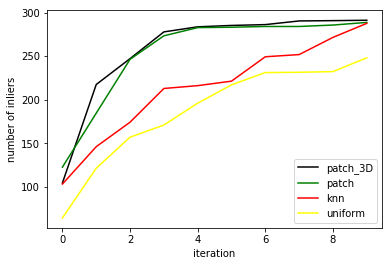

In [154]:
n_lines = (2, 2)
all_models = [(model_patch_3D_multi, 3, 2, False, "patch_3D"), (model_patch_multi, 2, 2, False, "patch"), (model_multi, 1, 2, False, "knn")]
compare_all_ransac_multi(sigma_noise, all_models, nbr_inliers, nbr_outliers, n_lines, size_patch=size_patch, scale_patch=scale_patch, average=20)


0
start ransac with model type 3 weights ref = False
iteration= 0
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 250
iteration= 5
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so far= 301
iteration= 1
nbr lines so far= 1
inliers removed so far= 301
nbr inliers total so far= 563
iteration= 5
nbr lines so far= 1
inliers removed so far= 301
nbr inliers total so far= 572
iteration= 10
nbr lines so far= 1
inliers removed so far= 301
nbr inliers total so far= 574
iteration= 0
nbr lines so far= 2
inliers removed so far= 574
nbr inliers total so far= 776
iteration= 1
nbr lines so far= 2
inliers removed so far= 574
nbr inliers total so far= 796
iteration= 5
nbr lines so far= 2
inliers removed so far= 574
nbr inliers total so far= 825
iteration= 1
nbr lines so far= 3
inliers removed so far= 825
nbr inliers total so far= 1093
start ransac with model type 2 weights ref = False
iteration= 1
nbr lines so far= 0
inliers removed so far= 0
nbr inliers total so

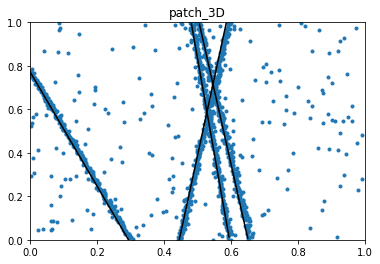

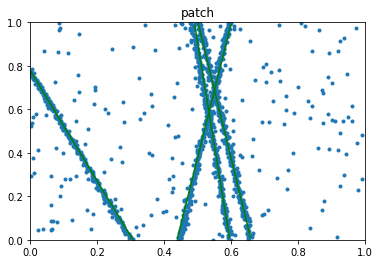

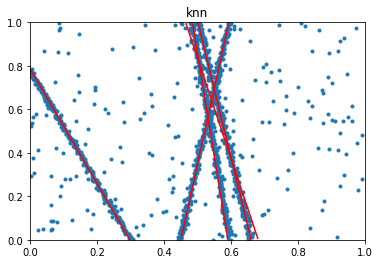

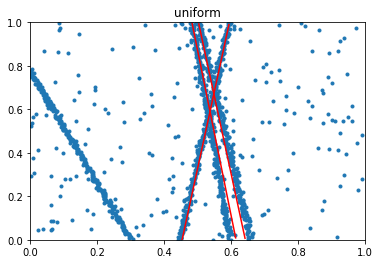

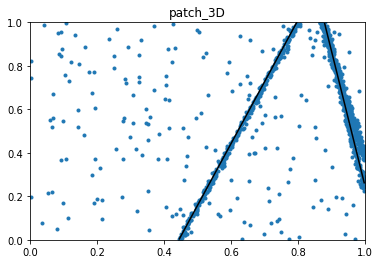

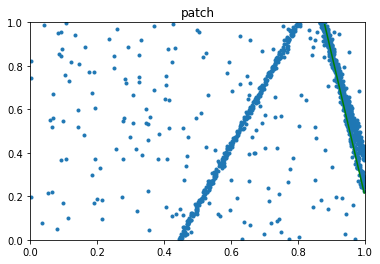

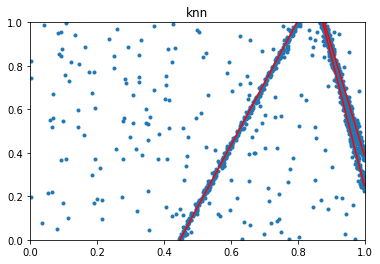

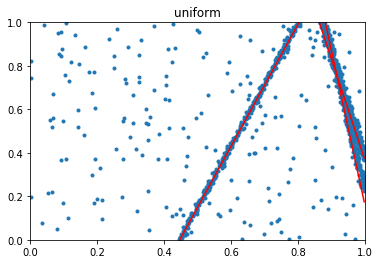

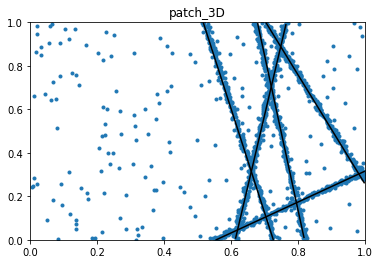

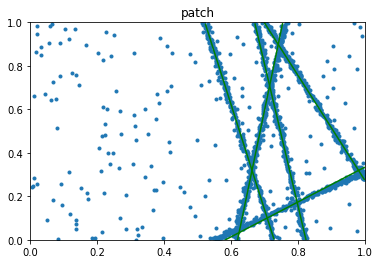

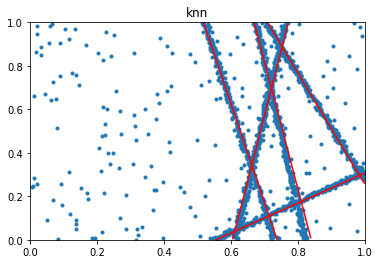

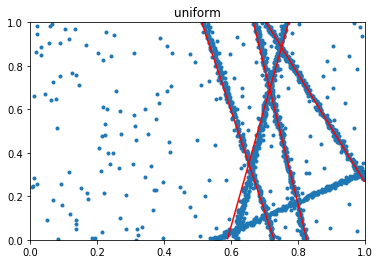

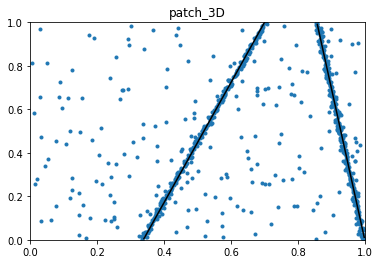

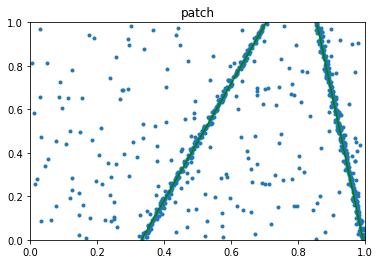

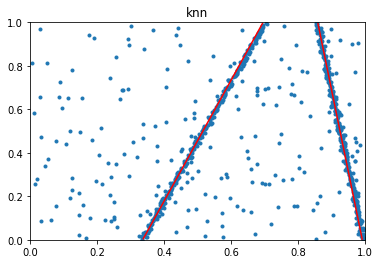

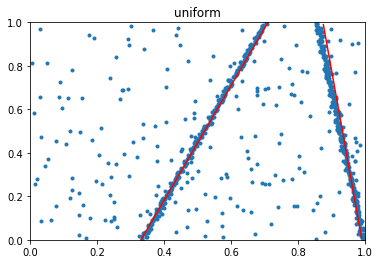

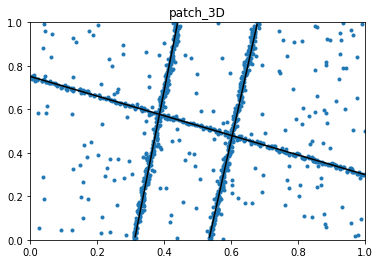

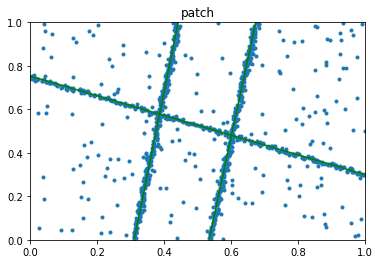

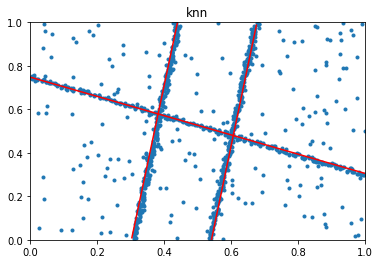

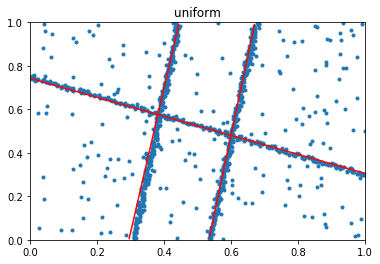

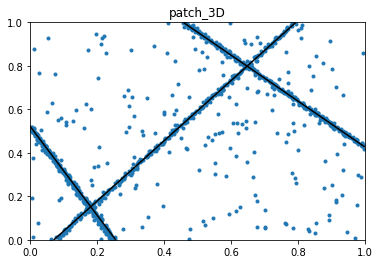

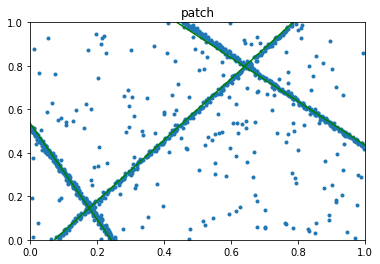

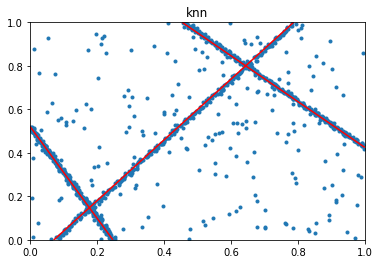

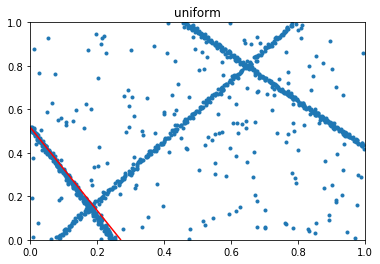

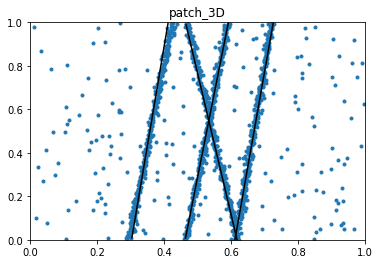

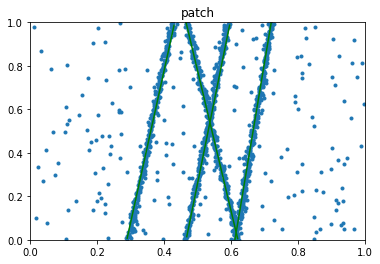

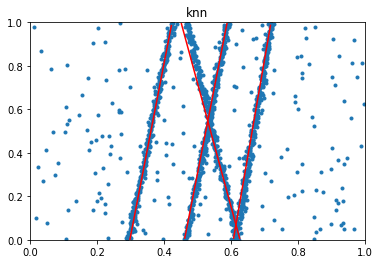

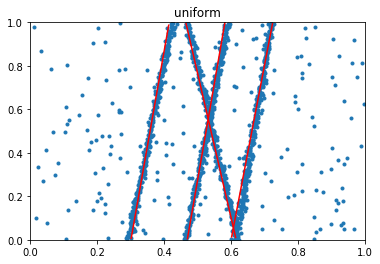

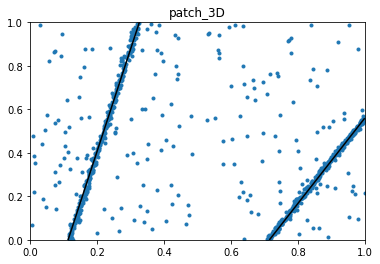

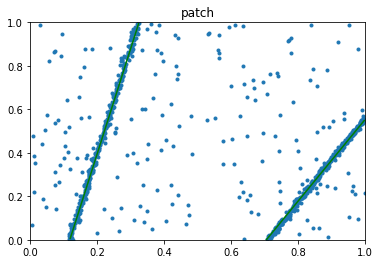

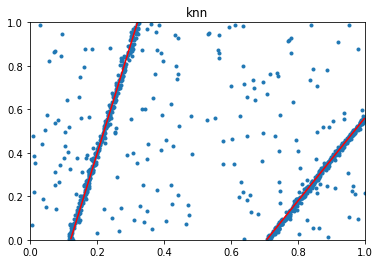

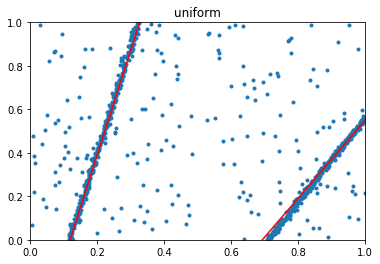

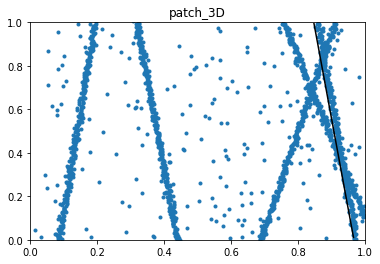

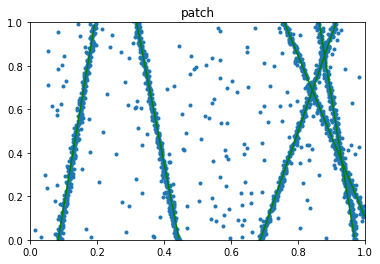

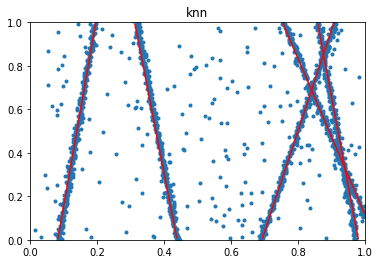

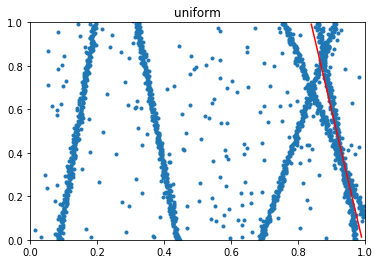

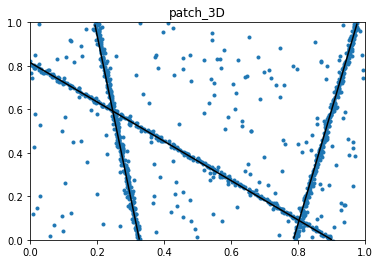

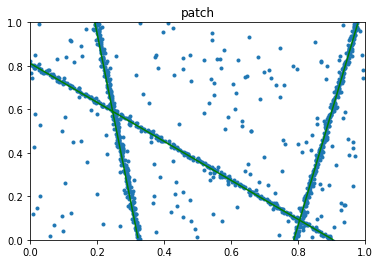

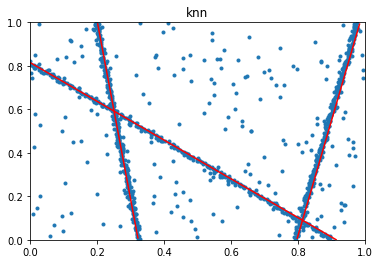

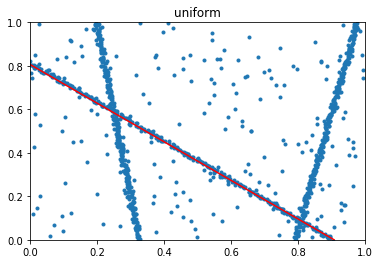

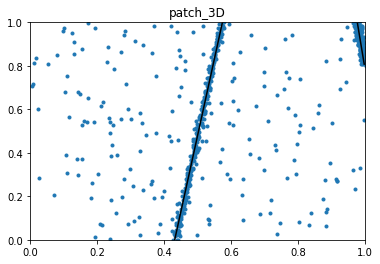

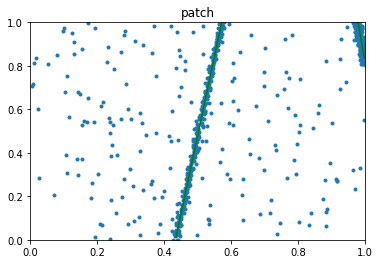

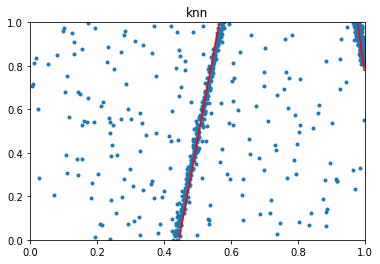

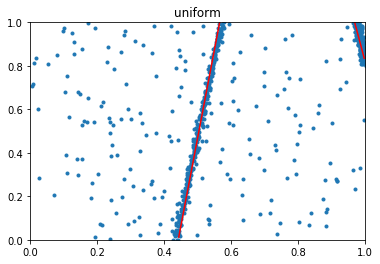

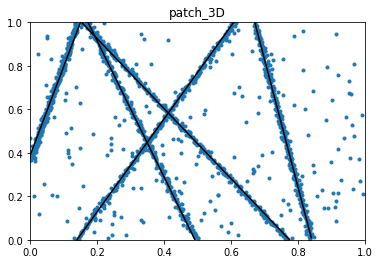

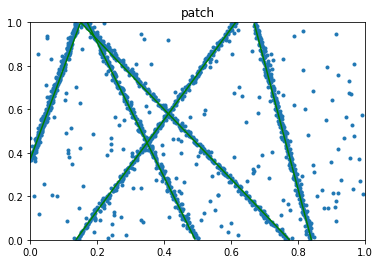

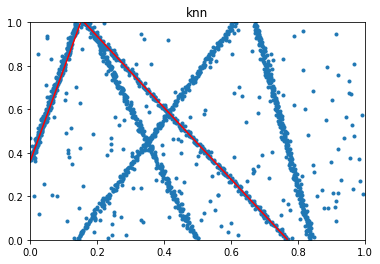

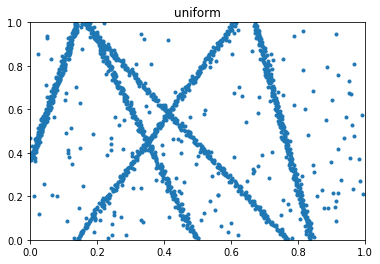

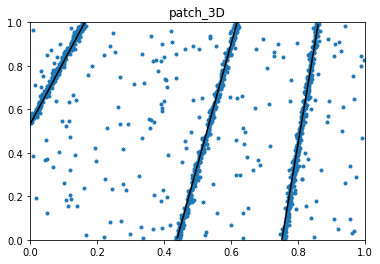

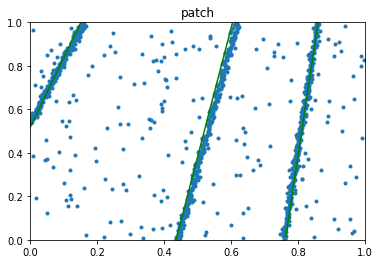

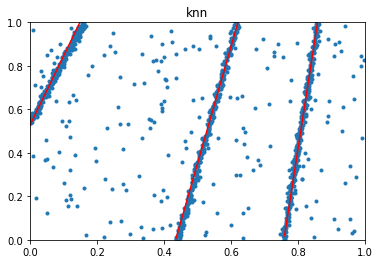

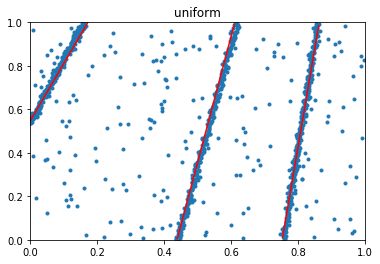

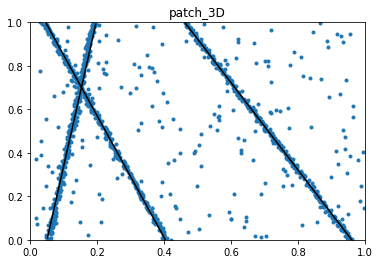

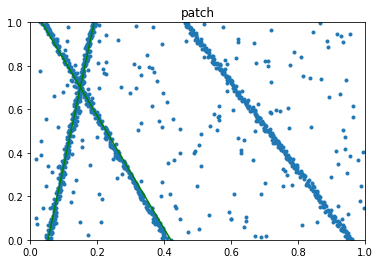

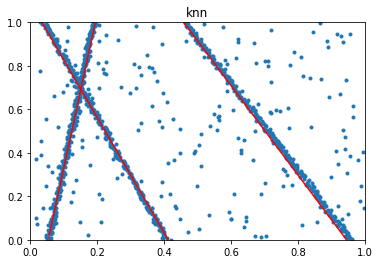

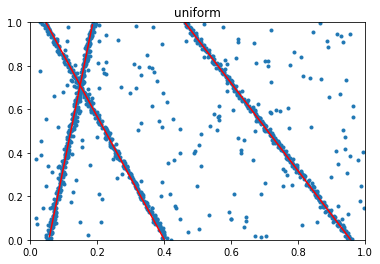

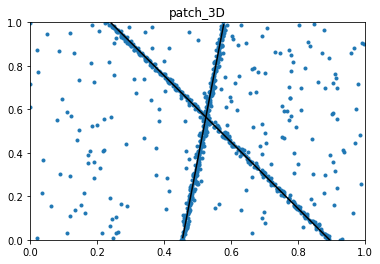

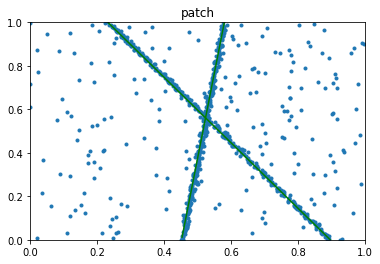

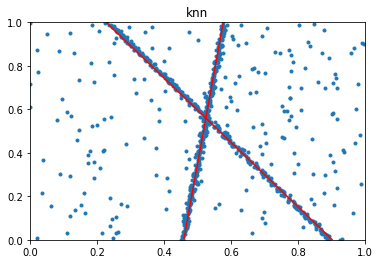

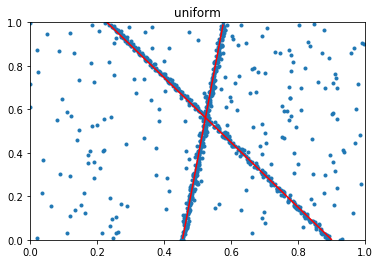

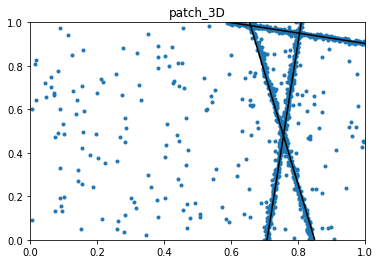

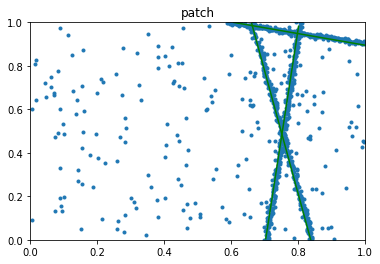

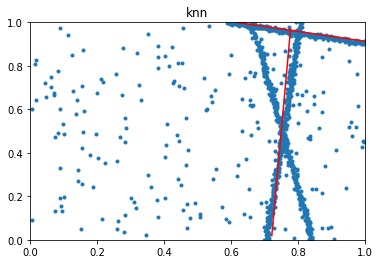

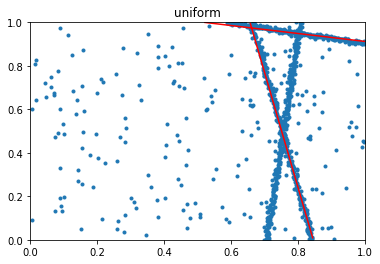

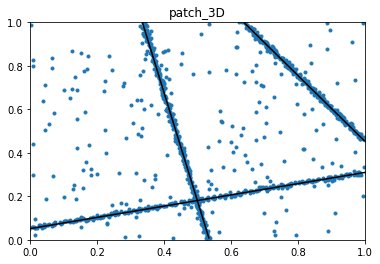

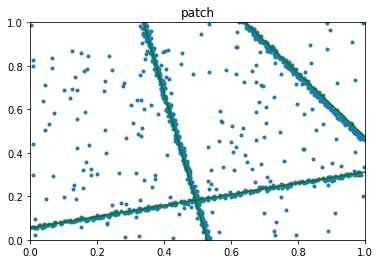

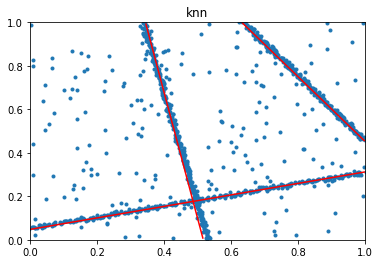

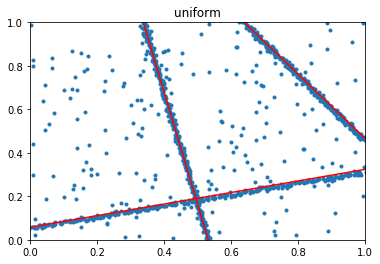

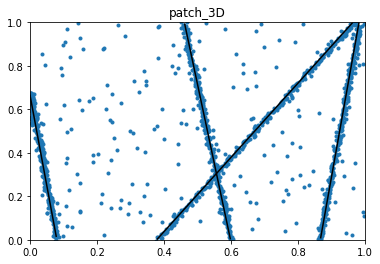

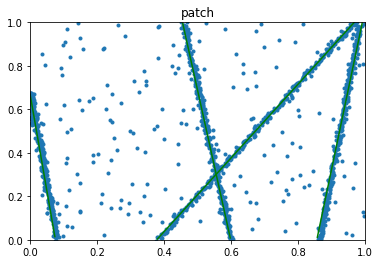

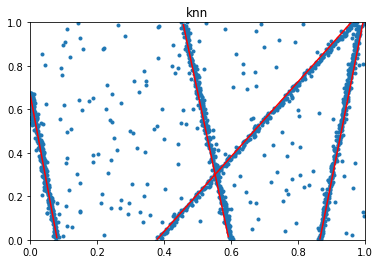

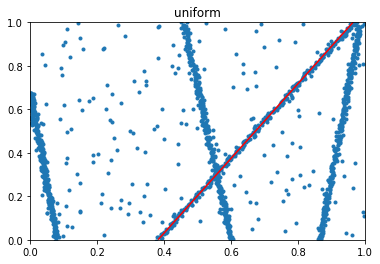

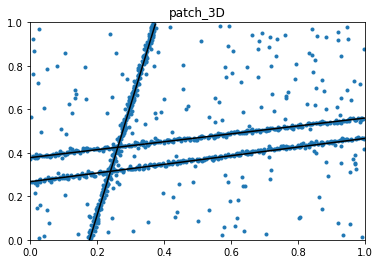

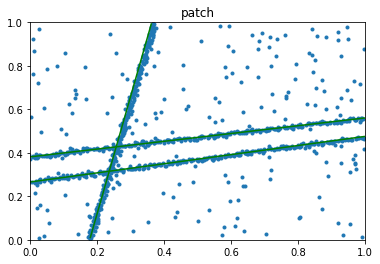

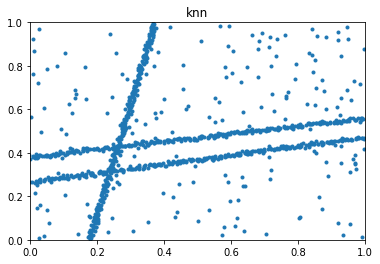

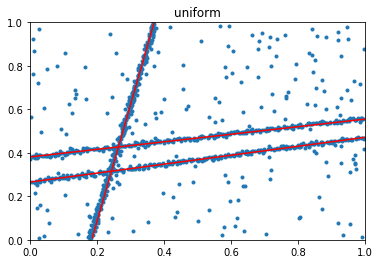

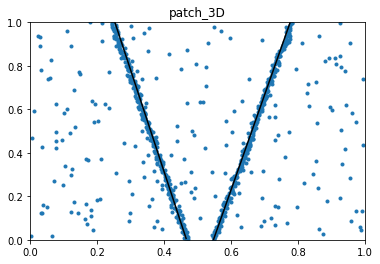

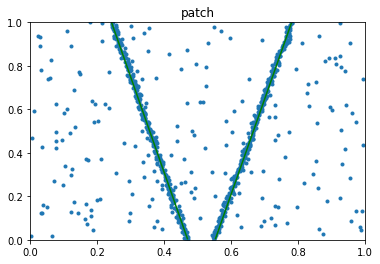

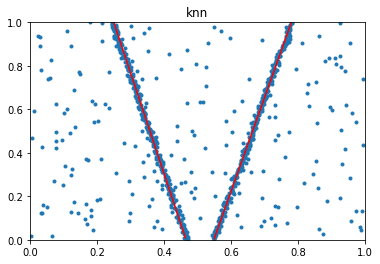

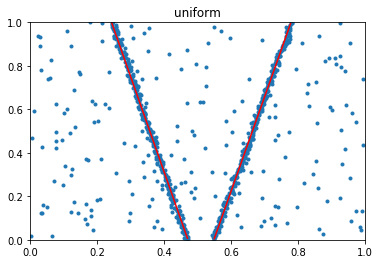

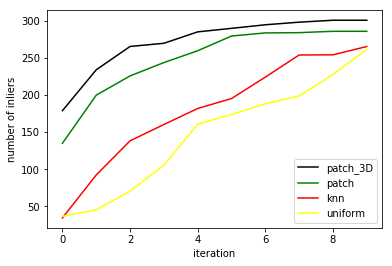

In [157]:
n_lines = (2, 5)
all_models = [(model_patch_3D_multi, 3, 2, False, "patch_3D"), (model_patch_multi, 2, 2, False, "patch"), (model_multi, 1, 2, False, "knn")]
compare_all_ransac_multi(sigma_noise, all_models, nbr_inliers, nbr_outliers, n_lines, size_patch=size_patch, scale_patch=scale_patch, average=20)


In [ ]:
compare_to_uniform_multi(sigma_noise, nbr_inliers, nbr_outliers, n_lines, type_loss=2, model=model_patch_3D_multi_load, model_type=3, size_patch=size_patch, scale_patch=scale_patch, average=1)